<a href="https://colab.research.google.com/github/ryyutku/DSGP/blob/anuk/Modelling/Model%204/Demand_forecast_model_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from scipy.stats import linregress
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import curve_fit
from scipy.stats import zscore
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf,pacf
import seaborn as sns

from statsmodels.tsa.stattools import adfuller

In [ ]:
files = ["Avg_Daily_Sales_Litres_ceypetco.csv","Avg_Daily_Sales_MT_ceypetco.csv","CIEC Data.csv","GDP_historical_data.csv","Import_Data_WITS.csv","Population_colombo.csv","Sales_IOC.csv","Transport_Report_Tables.csv" ]

In [ ]:
ceypetco_sales_l_df = pd.read_csv(files[0]) # int64
ceypetco_sales_m_df = pd.read_csv(files[1]) # int64
ciec_df = pd.read_csv(files[2]) # float64
gdp_df = pd.read_csv(files[3]) # converted to float64
import_df = pd.read_csv(files[4]) # contains float64, int64 for years, object for the partner names and countries
population_df = pd.read_csv(files[5]) # converted float64
ioc_sales_df = pd.read_csv(files[6]) # converted to float64
transport_df = pd.read_csv(files[7]) # converted to float64

In [ ]:
# Converting the ioc_sales data into float
ioc_sales_df = ioc_sales_df.replace({r'[\n,]': ''}, regex=True)
ioc_sales_df = ioc_sales_df.astype(float)

In [ ]:
# Converting the gdp historical data into float
gdp_df = gdp_df.replace({r'[$%B,]':''},regex=True)
gdp_df = gdp_df.replace('',np.nan)
gdp_df = gdp_df.astype(float)

In [ ]:
# converting the population df to float
population_df = population_df.replace({r'[,%]':''},regex=True)
population_df = population_df.replace('',np.nan)
population_df = population_df.astype(float)

In [ ]:
# converting the transport df to float
transport_df_str = transport_df.iloc[:,0:2]
transport_df_n = transport_df.iloc[:, 2:].replace({r'[,%]':''},regex=True)
transport_df_n = transport_df_n.astype(float)
transport_df = transport_df_str.join(transport_df_n)

In [ ]:
ciec_df['date'] = pd.to_datetime((ciec_df['date']))

In [ ]:
ciec_df.columns

Index(['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture'],
      dtype='object')

In [ ]:
ciec_df_cols = ['date', 'fuel_consumption', 'petroleum_imports_crudeOil',
       'Taxes_on_Customs_and_Other_Import Duties',
       'Foreign Direct Investments', 'GDP Goods and Services',
       'GDP: Gross National Income', 'Government Debt',
       'New Vehicle Registrations', 'Vehicle Sales', 'Port Stay Duration',
       'Vehicle Sales Asia', 'No.of Vessels Colombo',
       'Imports of Refined Products', 'Colombo port calls',
       'Tax income profits_gains', 'Tax on Export', 'Tax Goods & Services',
       'Tax Road Transport', 'GDP FCE Households', 'Diesel User Price',
       'Petrol User Price', 'Consumption_Oil', 'Sales 90 Octane',
       'Sales 95 Octane', 'Sales Auto Diesel', 'Household_income',
       'Fuel_other_manufacture']

In [ ]:
ciec_df.dtypes

,0
date,datetime64[ns]
fuel_consumption,float64
petroleum_imports_crudeOil,float64
Taxes_on_Customs_and_Other_Import Duties,float64
Foreign Direct Investments,float64
GDP Goods and Services,float64
GDP: Gross National Income,float64
Government Debt,float64
New Vehicle Registrations,float64
Vehicle Sales,float64


## **Checking the relationships of the columns to see how they must be interpolated**

Checking how the columns are related to other columns, For forecasting the null values

In [ ]:
def calculate_category_correlation(df,feature1, feature2):
    # Drop rows where 'feature1' is NaN
    df_valid_feature1 = df.dropna(subset=[feature1])

    # Drop rows where 'feature2' are NaN
    df_valid_feature2 = df.dropna(subset=[feature2], how='all')

    # Find the overlapping date range where both 'feature1' and the 'feature2' exist
    start_date = max(df_valid_feature1['date'].min(), df_valid_feature2['date'].min())
    end_date = min(df_valid_feature1['date'].max(), df_valid_feature2['date'].max())

    # Filter data to include only the overlapping date range
    df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Compute correlation between 'fuel_consumption' and the aggregated category
    correlation = df_filtered[[feature1, feature2]].corr().iloc[0, 1]

    return correlation

In [ ]:
def find_strong_correlations(df, columns, threshold=0.8):
  strong_correlations = {}
  for i in columns:
    for j in columns:
      if i != j:
        correlation = calculate_category_correlation(df, i, j)
        if abs(correlation) >= threshold:
          if i not in strong_correlations:
            strong_correlations[i] = []
          strong_correlations[i].append((j,correlation))


  if strong_correlations:
    print("THE STRONG CORRELATIONS")
    for feature, related_features  in strong_correlations.items():
      for related_feature, corr in related_features:
        print(f"{feature} and {related_feature} have a correlation of {corr:.2f}")
  else:
    print("NO STRONG CORRELATIONS")

  return strong_correlations


In [ ]:
strong_correlations = find_strong_correlations(ciec_df,ciec_df_cols)

THE STRONG CORRELATIONS
date and fuel_consumption have a correlation of 0.90
date and GDP Goods and Services have a correlation of 0.91
date and GDP: Gross National Income have a correlation of 0.93
date and Government Debt have a correlation of 0.94
date and Imports of Refined Products have a correlation of 0.88
date and Tax income profits_gains have a correlation of 0.81
date and Tax Goods & Services have a correlation of -0.93
date and GDP FCE Households have a correlation of 0.89
date and Petrol User Price have a correlation of -0.87
date and Consumption_Oil have a correlation of 0.94
date and Sales 90 Octane have a correlation of 0.96
date and Sales 95 Octane have a correlation of 0.83
date and Sales Auto Diesel have a correlation of 0.81
date and Household_income have a correlation of 0.82
fuel_consumption and date have a correlation of 0.90
fuel_consumption and Vehicle Sales have a correlation of 0.83
fuel_consumption and Petrol User Price have a correlation of -0.84
fuel_consum

In [ ]:
ciec_df.isnull().mean() *100

,0
date,0.000000
fuel_consumption,28.649535
petroleum_imports_crudeOil,8.747950
Taxes_on_Customs_and_Other_Import Duties,3.007108
Foreign Direct Investments,37.288136
GDP Goods and Services,57.900492
GDP: Gross National Income,57.900492
Government Debt,69.327501
New Vehicle Registrations,0.601422
Vehicle Sales,57.189721


**Null value analysis**\
0-10% - date, consumption_oil

10-30% - fuel_consumption, New Vehicle Registrations (Interpolation will be applied)

30-50% -petroleum_imports_crude_oil, Taxes_on_Customs_and_Other_Import Duties, Imports of Refined Products, Tax income profits_gains, Tax Goods & Services, Diesel User Price, Petrol User Price, Sales 90 Octane, Sales Auto Diesel,

50% + - Foreign Direct Investments, GDP Goods and Services, GDP: Gross National Income, GDP: Gross National Income, Government Debt, Vehicle Sales, Port Stay Duration, Vehicle Sales Asia, No.of Vessels Colombo, Colombo port calls, Tax on Export, Tax Road Transport, GDP FCE Households, Sales 95 Octane, Household_income, Fuel_other_manufacture. (Interplation will be applied)

**Need to cutdown the range from which data is considered, few possible time frames to start with are 1990,1999,2005,2006,2010 **

In [ ]:
def get_correlating_list(feature, dict):
  list = []
  values = dict[feature]
  for v1,v2 in values:
    list.append(v1)
  return list

In [ ]:
proxy_df = pd.DataFrame()

In [ ]:
# Making a copy of ciec_df
df = ciec_df.copy()

## **Scaling The data**

In [ ]:
scaler = StandardScaler()
m_scaler = MinMaxScaler()

Using z-score scaling (Standard Scaler) for the columns following normal distribution

In [ ]:
z_cols = ['fuel_consumption', 'GDP: Gross National Income', 'GDP Goods and Services',
          'Foreign Direct Investments', 'Household_income', 'Tax income profits_gains',
          'Tax on Export', 'Tax Goods & Services', 'Tax Road Transport', 'Government Debt', 'Vehicle Sales']

In [ ]:
df[z_cols] = scaler.fit_transform(ciec_df[z_cols])

Using min-max scaling for price related values

In [ ]:
m_cols = ['Diesel User Price', 'Petrol User Price', 'petroleum_imports_crudeOil','Imports of Refined Products', 'Consumption_Oil']

In [ ]:
df[m_cols] = m_scaler.fit_transform(ciec_df[m_cols])

Adding log transformation for highly skewed data

In [ ]:
l_cols = ['GDP: Gross National Income', 'Foreign Direct Investments', 'Household_income', 'Tax income profits_gains']

In [ ]:
df[l_cols] = np.log1p(df[l_cols])

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


## **Building Proxy features for the columns using the columns inside the df**

In [ ]:
# from sklearn.linear_model import LinearRegression
# import numpy as np
# import pandas as pd

# def fill_missing_with_regression(df, target_feature, correlated_features):
#     df = df.copy()  # Avoid modifying original DataFrame

#     if 'date' in correlated_features:
#       correlated_features.remove('date')

#     # Find missing values in the target column
#     missing_mask = df[target_feature].isna()

#     # Drop rows where either the target or any correlated feature is NaN
#     valid_data = df.dropna(subset=[target_feature] + correlated_features)

#     if valid_data.empty:
#         print(f"Not enough valid data to train regression for {target_feature}.")
#         return df  # Return original DF if no valid training data

#     # Define X (independent variables) and y (dependent variable)
#     X_train = valid_data[correlated_features]
#     y_train = valid_data[target_feature]

#     # Train regression model
#     model = LinearRegression()
#     model.fit(X_train, y_train)

#     # Find rows where target_feature is missing but correlated features exist
#     X_missing = df.loc[missing_mask, correlated_features].dropna()

#     if X_missing.empty:
#         print(f"No valid correlated features available to predict missing {target_feature}.")
#         return df  # No valid data to fill missing values

#     # Predict missing values
#     predicted_values = model.predict(X_missing)

#     # Fill missing values with predicted values
#     df.loc[X_missing.index, target_feature] = predicted_values

#     return df



In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

def fill_missing_with_regression(df, target_feature, correlated_features):
    df = df.copy()  # Avoid modifying original DataFrame

    # Ensure 'date' column is not used
    correlated_features = [col for col in correlated_features if col != 'date']

    # Check if correlated features exist
    if len(correlated_features) == 0:
        print(f"No valid correlated features for {target_feature}.")
        return df

    # Find missing values in the target column
    missing_mask = df[target_feature].isna()

    # Drop rows where either the target or any correlated feature is NaN
    valid_data = df.dropna(subset=[target_feature] + correlated_features)

    # Debug: Print how many rows are valid
    print(f"Valid data available for {target_feature}: {len(valid_data)} rows")

    if valid_data.empty:
        print(f"Not enough valid data to train regression for {target_feature}.")
        return df  # Return original DF if no valid training data

    # Fill missing values in correlated features (forward + backward fill)
    df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')

    # Define X (independent variables) and y (dependent variable)
    X_train = valid_data[correlated_features]
    y_train = valid_data[target_feature]

    # Convert data types to float
    X_train = X_train.astype(float)
    y_train = y_train.astype(float)

    # Train regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Find rows where target_feature is missing but correlated features exist
    X_missing = df.loc[missing_mask, correlated_features].dropna()

    # Debug: Print how many missing rows can be filled
    print(f"Missing values to predict for {target_feature}: {len(X_missing)} rows")

    if X_missing.empty:
        print(f"No valid correlated features available to predict missing {target_feature}.")
        return df  # No valid data to fill missing values

    # Convert missing data to float
    X_missing = X_missing.astype(float)

    # Predict missing values
    predicted_values = model.predict(X_missing)

    # Fill missing values with predicted values
    df.loc[X_missing.index, target_feature] = predicted_values

    return df


In [ ]:
# Filling missing values for 'fuel_consumption'
fuel_consumption_list = get_correlating_list('fuel_consumption', strong_correlations)
df = fill_missing_with_regression(df, 'fuel_consumption', fuel_consumption_list[:5])

Valid data available for fuel_consumption: 522 rows
Missing values to predict for fuel_consumption: 524 rows


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['fuel_consumption'].corr(df['fuel_consumption'])

0.9999999999999998

In [ ]:
df['fuel_consumption'].isnull().mean()

0.0

In [ ]:
# Filling missing values for 'GDP Goods and Services'
GDP_Goods_Services_list = get_correlating_list('GDP Goods and Services', strong_correlations)
df = fill_missing_with_regression(df, 'GDP Goods and Services', GDP_Goods_Services_list[:5])

Valid data available for GDP Goods and Services: 521 rows
Missing values to predict for GDP Goods and Services: 1059 rows


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['GDP Goods and Services'].corr(df['GDP Goods and Services'])

1.0

In [ ]:
df['GDP Goods and Services'].isnull().mean()

0.0

In [ ]:
# Filling missing values for 'GDP: Gross National Income'
GDP_Gross_National_Income_list = get_correlating_list('GDP: Gross National Income', strong_correlations)
df = fill_missing_with_regression(df, 'GDP: Gross National Income', GDP_Gross_National_Income_list[:5])

Valid data available for GDP: Gross National Income: 1829 rows
Missing values to predict for GDP: Gross National Income: 0 rows
No valid correlated features available to predict missing GDP: Gross National Income.


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['GDP: Gross National Income'].corr(df['GDP: Gross National Income'])

0.9050850073862409

In [ ]:
df['GDP: Gross National Income'].isnull().mean()

0.0

In [ ]:
# Filling values for 'Government Debt'
Government_Debt_list = get_correlating_list('Government Debt', strong_correlations)
df = fill_missing_with_regression(df, 'Government Debt', Government_Debt_list[:5])

Valid data available for Government Debt: 1818 rows
Missing values to predict for Government Debt: 0 rows
No valid correlated features available to predict missing Government Debt.


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['Government Debt'].corr(df['Government Debt'])

1.0

In [ ]:
df['Government Debt'].isnull().mean()

0.0

In [ ]:
# Filling for 'Vehicle Sales'
Vehicle_Sales_list = get_correlating_list('Vehicle Sales', strong_correlations)
df = fill_missing_with_regression(df, 'Vehicle Sales', Vehicle_Sales_list[:5])

Valid data available for Vehicle Sales: 105 rows
Missing values to predict for Vehicle Sales: 0 rows
No valid correlated features available to predict missing Vehicle Sales.


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['Vehicle Sales'].corr(df['Vehicle Sales'])

1.0

In [ ]:
df['Vehicle Sales'].isnull().mean()

0.0

In [ ]:
# For 'Tax on Export'
tax_on_export_list = get_correlating_list('Tax on Export', strong_correlations)
df = fill_missing_with_regression(df,'Tax on Export',tax_on_export_list[:5])

Valid data available for Tax on Export: 1829 rows
Missing values to predict for Tax on Export: 0 rows
No valid correlated features available to predict missing Tax on Export.


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
df['Tax on Export'].isnull().mean()

0.0

In [ ]:
ciec_df['Tax on Export'].corr(df['Tax on Export'])

1.0

In [ ]:
# for 'Tax on Road Transport'
tax_road_transport_list = get_correlating_list('Tax Road Transport', strong_correlations)
df = fill_missing_with_regression(df,'Tax Road Transport',tax_road_transport_list[:5])

Valid data available for Tax Road Transport: 887 rows


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


Missing values to predict for Tax Road Transport: 942 rows


In [ ]:
df['Tax Road Transport'].isnull().mean()

0.0

In [ ]:
df['Tax Road Transport'].corr(ciec_df['Tax Road Transport'])

1.0

'Tax Road Transport' still has a high values

In [ ]:
# GDP FCE Households
gdp_fce_households_list = get_correlating_list('GDP FCE Households', strong_correlations)
df = fill_missing_with_regression(df,'GDP FCE Households',gdp_fce_households_list[:5])

Valid data available for GDP FCE Households: 1829 rows
Missing values to predict for GDP FCE Households: 0 rows
No valid correlated features available to predict missing GDP FCE Households.


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['GDP FCE Households'].corr(df['GDP FCE Households'])

1.0

In [ ]:
df['GDP FCE Households'].isnull().mean()

0.0

In [ ]:
# For 'Sales 95 Octane'
sales_95_octane_list = get_correlating_list('Sales 95 Octane', strong_correlations)
df = fill_missing_with_regression(df,'Sales 95 Octane',sales_95_octane_list[:5])

Valid data available for Sales 95 Octane: 1252 rows


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


Missing values to predict for Sales 95 Octane: 577 rows


In [ ]:
df['Sales 95 Octane'].isnull().mean()

0.0

In [ ]:
ciec_df['Sales 95 Octane'].corr(df['Sales 95 Octane'])


1.0

In [ ]:
# For 'Fuel and other manufacture'
fuel_other_manufacture_list = get_correlating_list('Fuel_other_manufacture', strong_correlations)
df = fill_missing_with_regression(df,'Fuel_other_manufacture',fuel_other_manufacture_list[:5])

Valid data available for Fuel_other_manufacture: 569 rows
Missing values to predict for Fuel_other_manufacture: 1260 rows


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
df['Fuel_other_manufacture'].isnull().mean()

0.0

In [ ]:
ciec_df['Fuel_other_manufacture'].corr(df['Fuel_other_manufacture'])

0.9999999999999998

In [ ]:
# For 'petroleum_import_crudeOil'
petroleum_imports_crudeOil_list = get_correlating_list('petroleum_imports_crudeOil', strong_correlations)
df = fill_missing_with_regression(df,'petroleum_imports_crudeOil',petroleum_imports_crudeOil_list[:5])

Valid data available for petroleum_imports_crudeOil: 1617 rows
Missing values to predict for petroleum_imports_crudeOil: 160 rows


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['petroleum_imports_crudeOil'].corr(df['petroleum_imports_crudeOil'])

0.9999999999999994

In [ ]:
df['petroleum_imports_crudeOil'].isnull().mean()

0.0

In [ ]:
# For 'Imports of Refined Products'
Imports_of_Refined_Products_list = get_correlating_list('Imports of Refined Products', strong_correlations)
df = fill_missing_with_regression(df,'Imports of Refined Products',Imports_of_Refined_Products_list[:5])

Valid data available for Imports of Refined Products: 1669 rows
Missing values to predict for Imports of Refined Products: 160 rows


<ipython-input-164-6f582fdff773>:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[correlated_features] = df[correlated_features].fillna(method='ffill').fillna(method='bfill')


In [ ]:
ciec_df['Imports of Refined Products'].corr(df['Imports of Refined Products'])

1.0

#### **Summary of performing regression filling**

In [ ]:
df.isnull().mean() *100

,0
date,0.000000
fuel_consumption,0.000000
petroleum_imports_crudeOil,0.000000
Taxes_on_Customs_and_Other_Import Duties,3.007108
Foreign Direct Investments,42.974303
GDP Goods and Services,0.000000
GDP: Gross National Income,0.000000
Government Debt,0.000000
New Vehicle Registrations,0.000000
Vehicle Sales,0.000000


The following columns doesnt have any strong correlations \
'Foreign Direct Investments' \
'Household_income' \
'Colombo port calls' \
'Port Stay Duration' \
'No.of Vessels Colombo' \

In [ ]:
df['Taxes_on_Customs_and_Other_Import Duties'] = df['Taxes_on_Customs_and_Other_Import Duties'].fillna(df['Taxes_on_Customs_and_Other_Import Duties'].mean())

## **Analyzing Data**

In [ ]:
outlier_df = df.drop(columns=['Household_income','Colombo port calls','No.of Vessels Colombo','Port Stay Duration','Foreign Direct Investments'])

**Detecting Outliers**

In [ ]:
#Detecting outliers using Zscore
def detect_outliers_zscore(df, feature, threshold=2, time_column='date'):
    df = df.copy()

    # # Drop rows with missing values in the feature column
    # if df.isna().sum() > 0:
    #     df = df.dropna(subset=[feature])

    # Calculate Z-scores for the feature
    df['zscore'] = zscore(df[feature])

    # Identify anomalies based on the Z-score threshold (e.g., z > 2 or z < -2)
    df[feature + '_isanomaly'] = (df['zscore'] > threshold) | (df['zscore'] < -threshold)

    # Filter anomaly data
    anomalies = df[df[feature + '_isanomaly']]

    # Display anomalies numerically (columns: time, feature, zscore, and anomaly flag)
    print("Anomalies detected:")
    print(anomalies[[time_column, feature, 'zscore', feature + '_isanomaly']])

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df[time_column], y=df[feature], label='Data', color='blue')

    # Highlight anomalies using larger markers
    sns.scatterplot(x=anomalies[time_column], y=anomalies[feature], color='red', label='Anomalies', s=100, marker='X')

    # Adding labels, title, and legend
    plt.title(f"{feature} Anomalies Over Time (Z-score method)")
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()

    # Show plot
    plt.show()

    anomalies.head(3)

    return anomalies, df


In [ ]:
anomalies = pd.DataFrame()
df_with_anomalies = pd.DataFrame()

In [ ]:
# for feature in outlier_df.columns:
#   anomalies, df_with_anomalies = detect_outliers_zscore(outlier_df, feature)


In [ ]:
anomalies.head()

""


In [ ]:
#Detecting outlier using IQR
def detect_outliers(df, feature, time_column='date'):
    df = df.copy()

    # Drop rows with missing values in the feature column
    # if df.isna().sum() > 0:
    #     df = df.dropna(subset=[feature])

    # Calculate IQR
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify anomalies
    df[feature + '_isanomaly'] = (df[feature] < lower_bound) | (df[feature] > upper_bound)

    # Filter anomaly data
    anomalies = df[df[feature + '_isanomaly']]

    # Plot data and anomalies over time using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df[time_column], y=df[feature], label='Data', color='blue')

    # Highlight anomalies using larger markers
    sns.scatterplot(x=anomalies[time_column], y=anomalies[feature], color='red', label='Anomalies', s=100, marker='X')

    # Adding labels, title, and legend
    plt.title(f"{feature} Anomalies Over Time")
    plt.xlabel('Time')
    plt.ylabel(feature)
    plt.legend()

    # Show plot
    plt.show()

    return anomalies, df

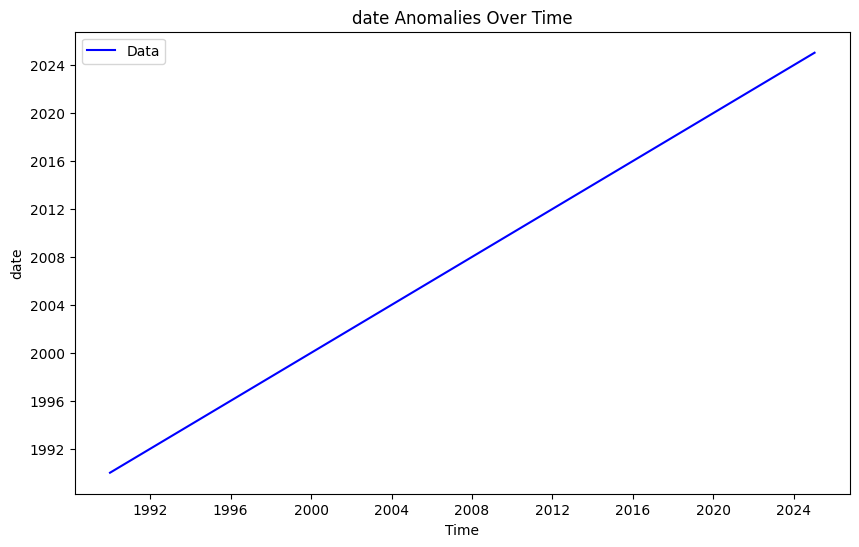

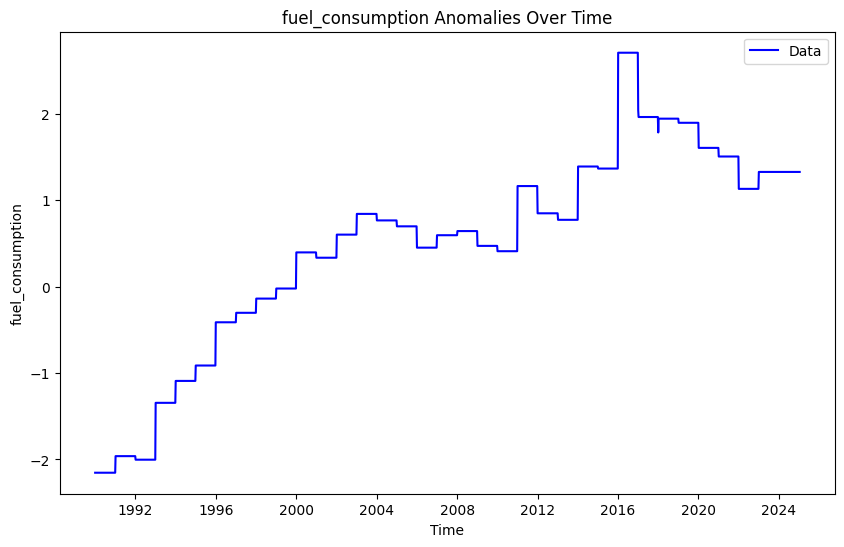

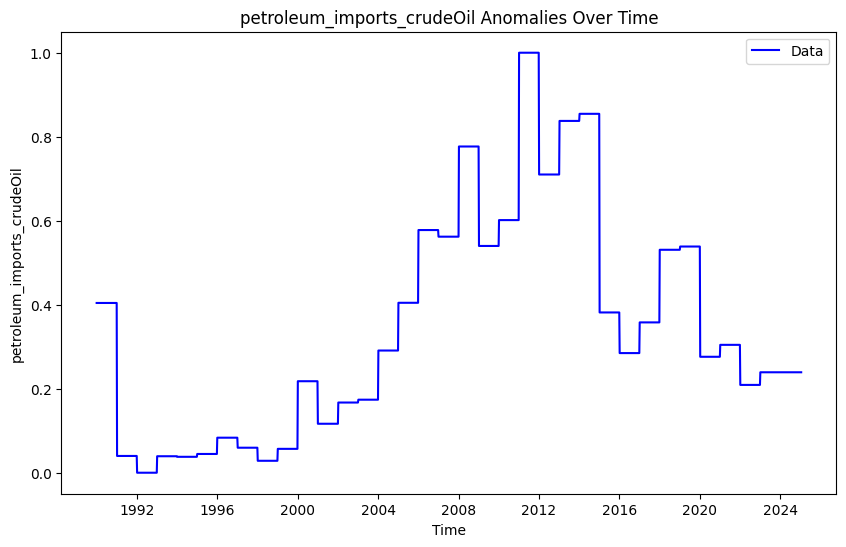

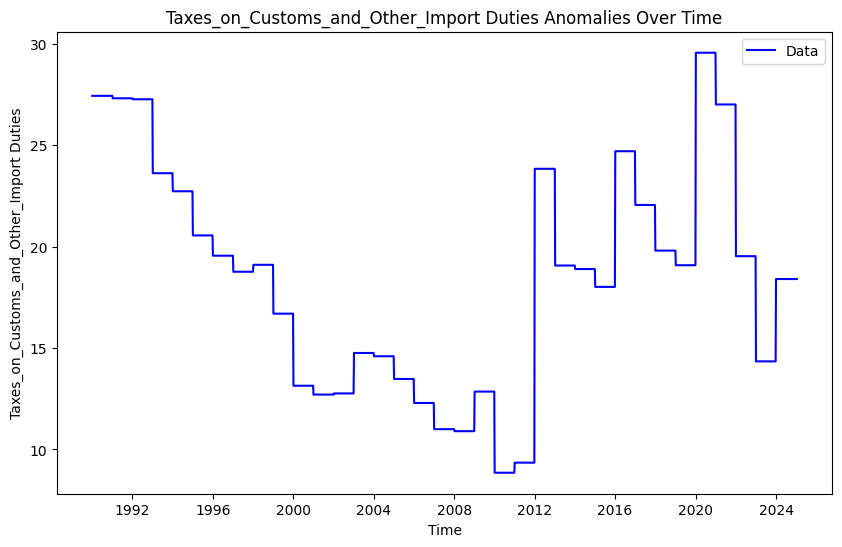

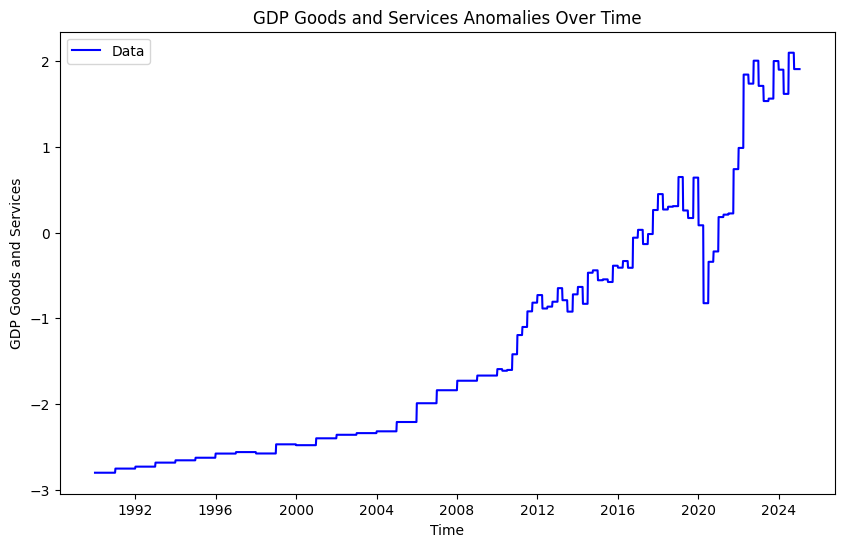

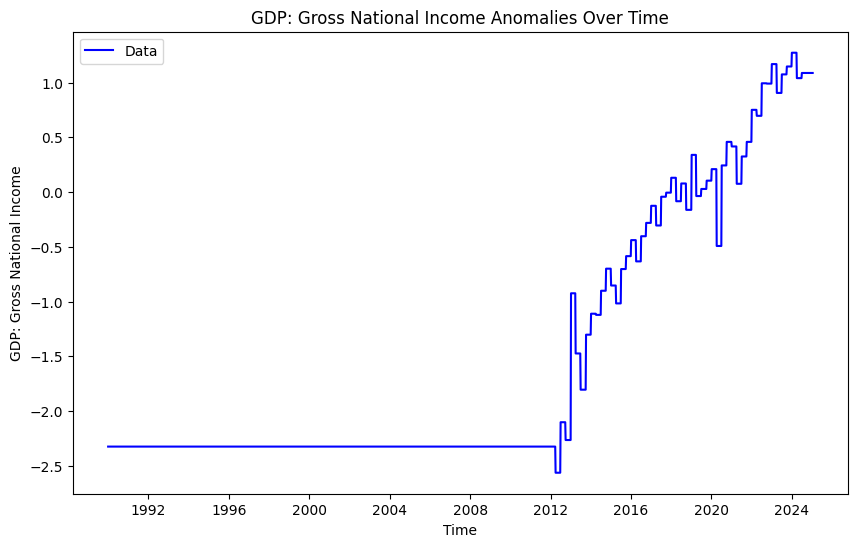

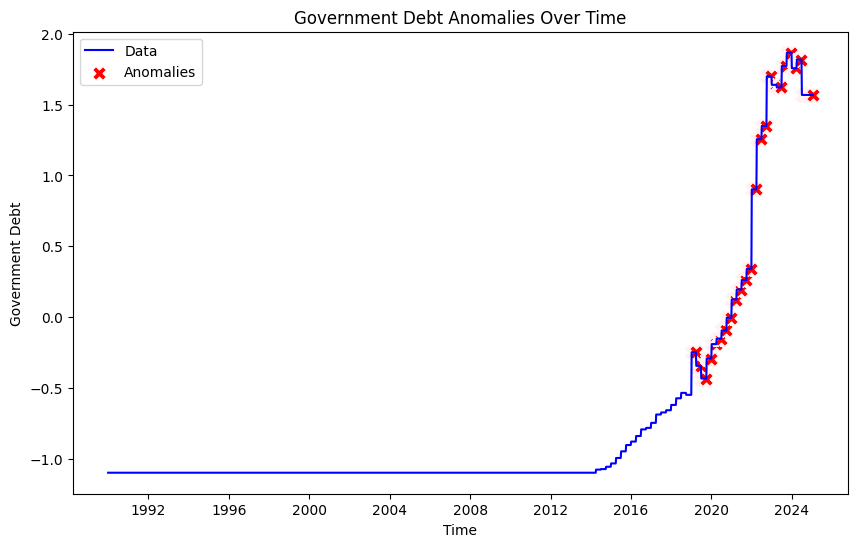

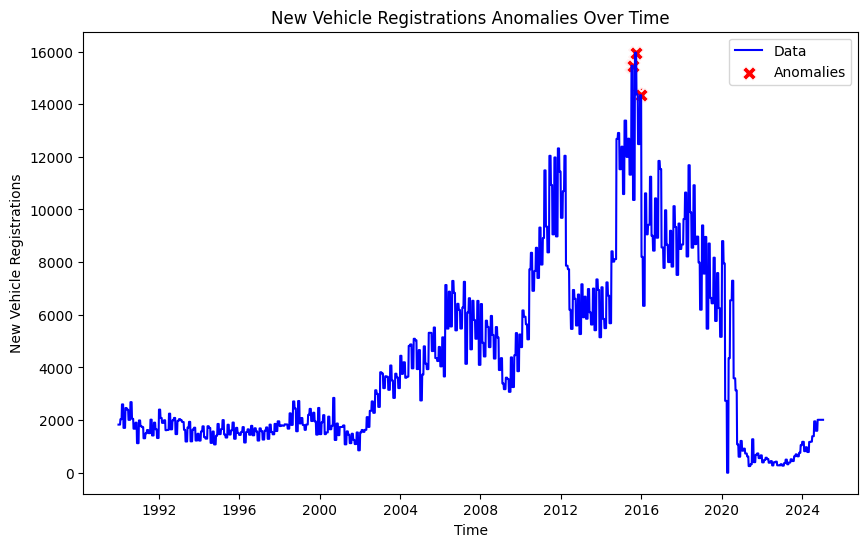

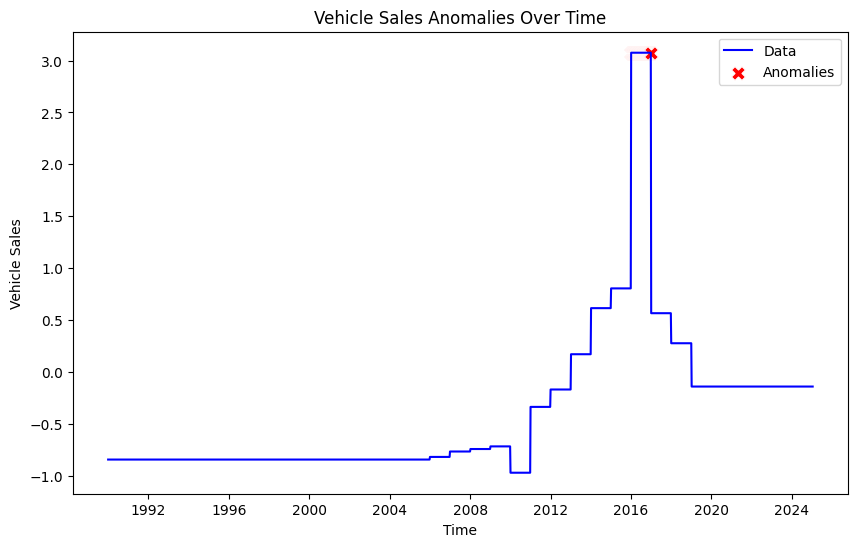

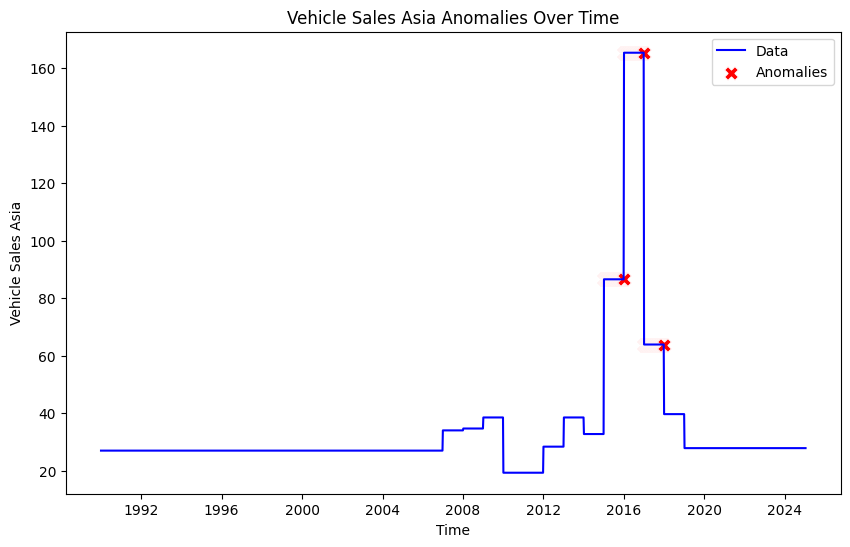

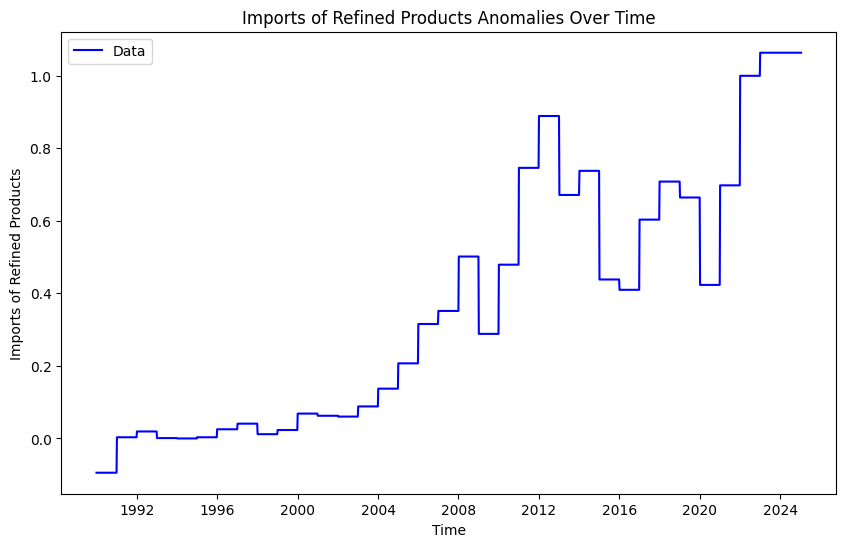

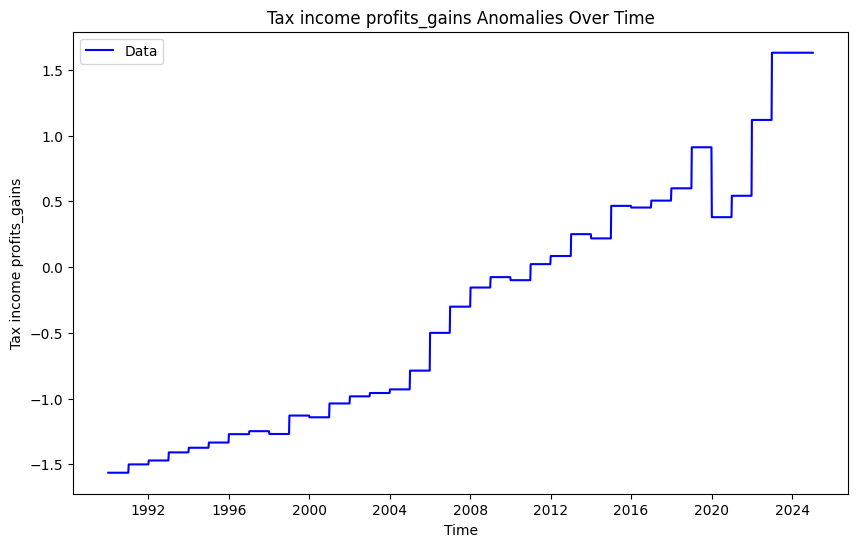

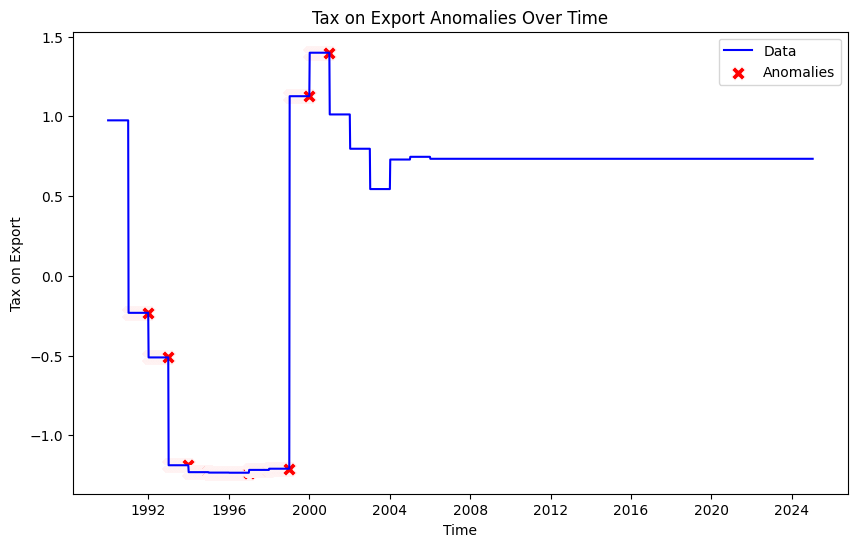

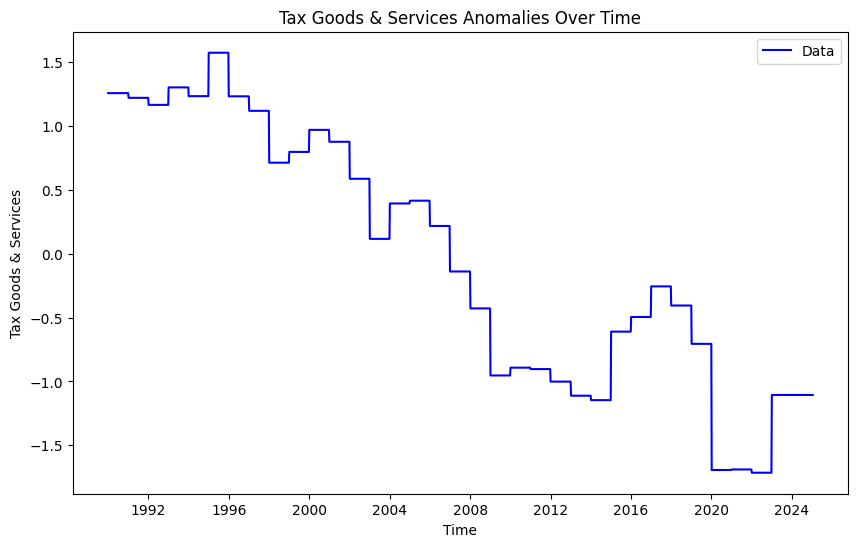

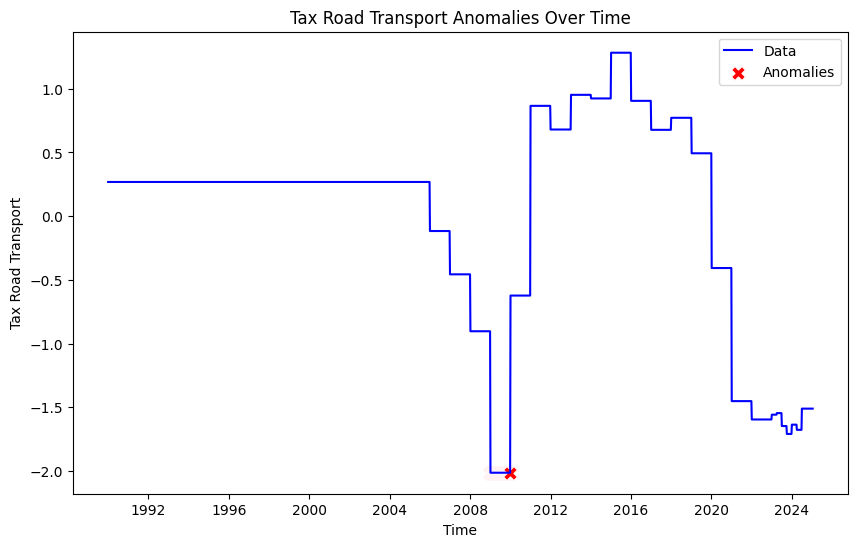

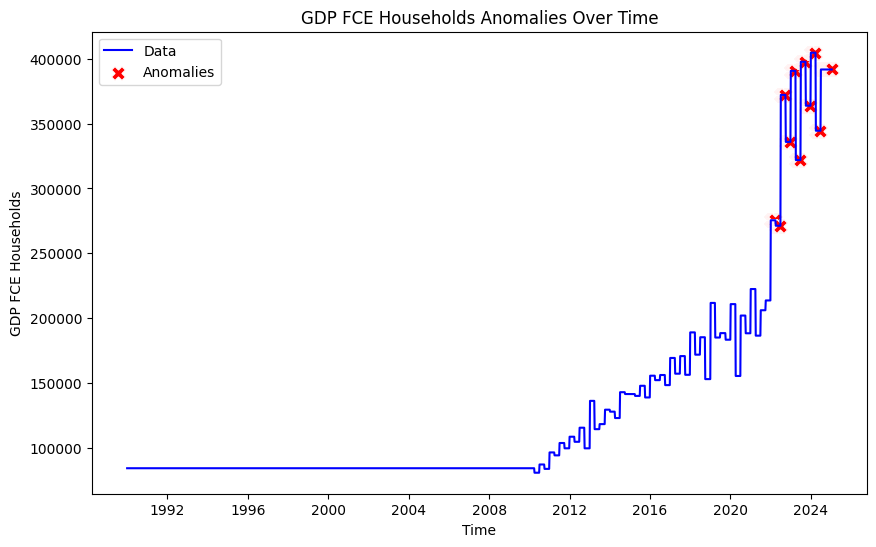

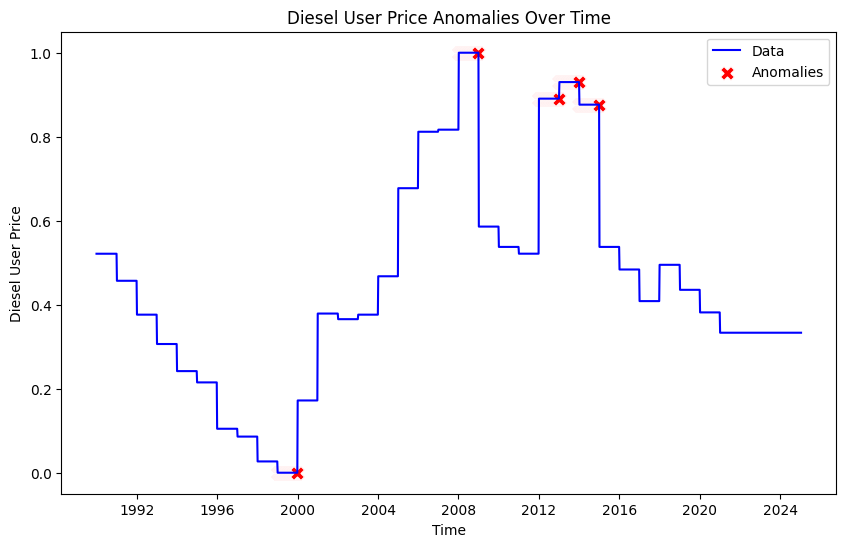

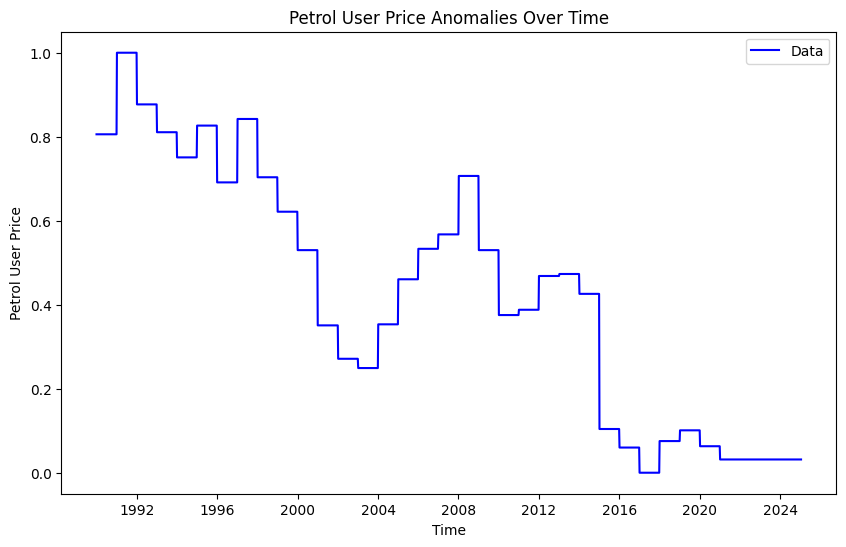

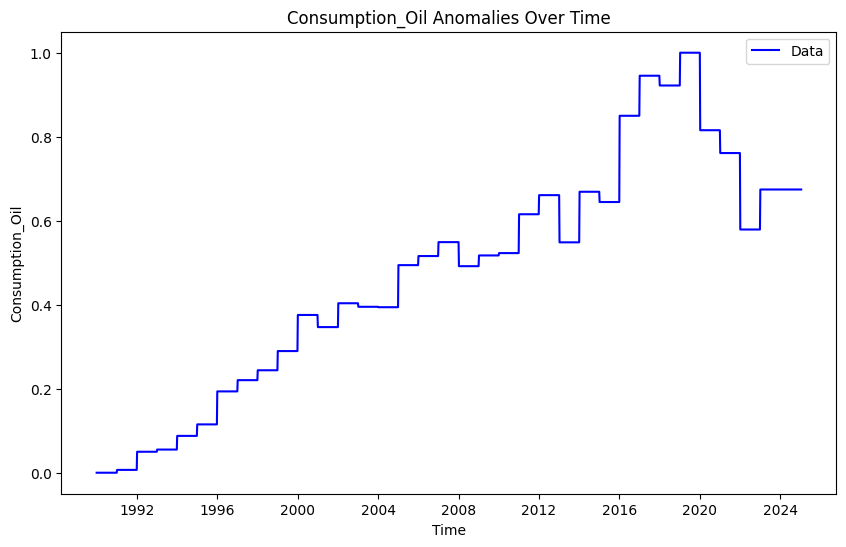

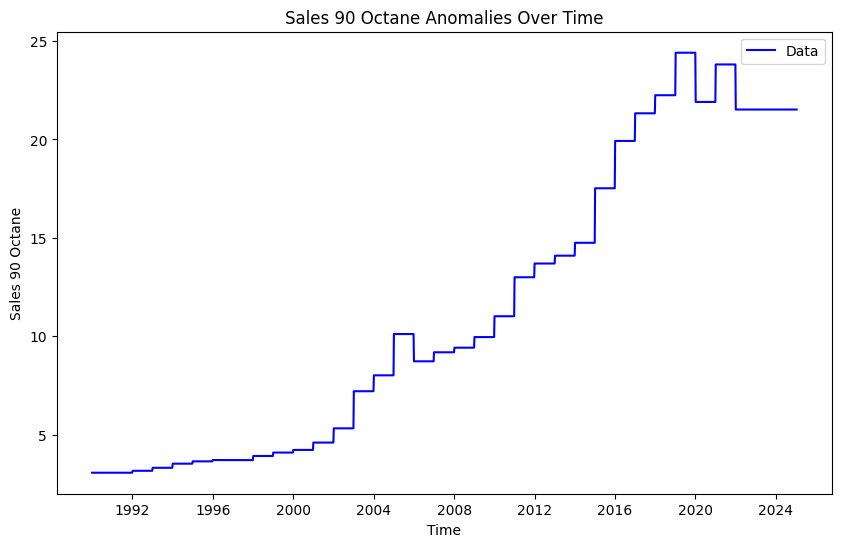

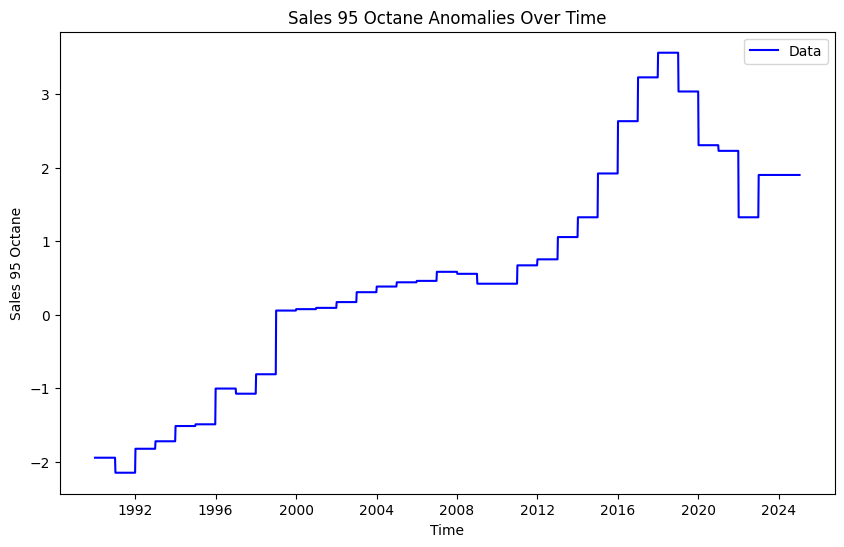

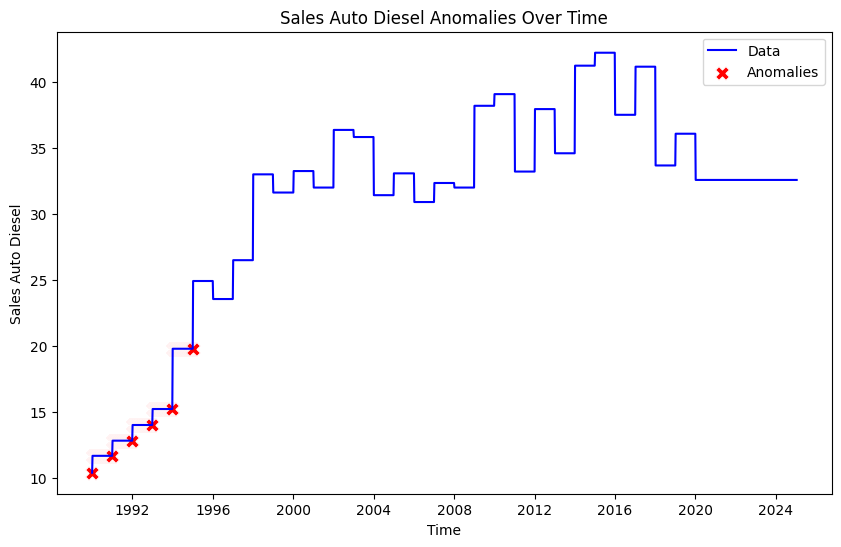

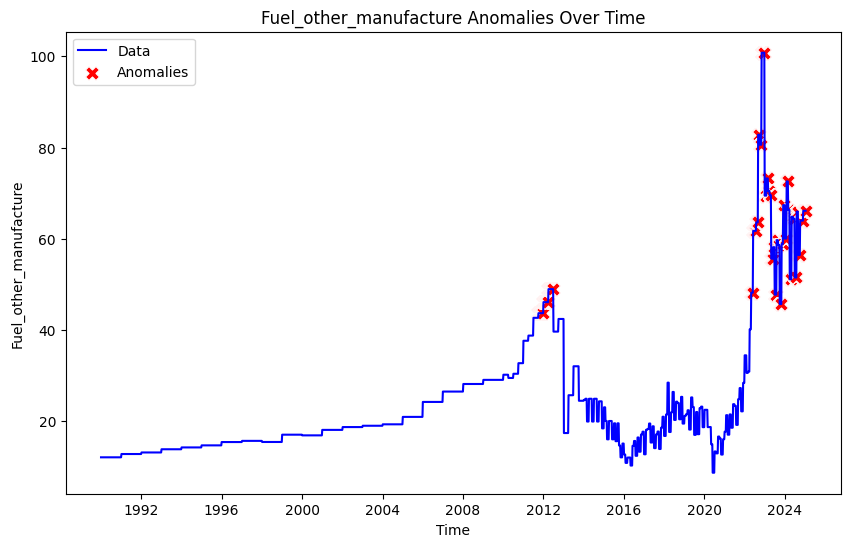

In [ ]:
for feature in outlier_df.columns:
  anomalies, df_with_anomalies = detect_outliers(outlier_df, feature)

In [ ]:
# Using ARIMA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

def detect_anomalies_arima_all(df, order=(5,1,0), threshold_factor=3):
    """
    Detects anomalies in all numerical columns of a DataFrame using ARIMA residuals.

    Parameters:
        df (pd.DataFrame): DataFrame containing the time series data.
        order (tuple): ARIMA order (p, d, q). Default is (5,1,0).
        threshold_factor (int): The number of standard deviations to use as an anomaly threshold.

    Returns:
        all_anomalies (dict): Dictionary where keys are column names and values are DataFrames with detected anomalies.
        df (pd.DataFrame): Original DataFrame with additional anomaly columns.
    """
    df = df.copy()
    all_anomalies = {}

    # Get numerical columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for feature in numeric_cols:
        print(f"\nProcessing column: {feature}")

        try:
            # Fit ARIMA model
            model = ARIMA(df[feature], order=order)
            model_fit = model.fit()

            # Predict values using ARIMA
            df[f'{feature}_predicted'] = model_fit.fittedvalues

            # Compute residuals (absolute error)
            df[f'{feature}_residual'] = abs(df[feature] - df[f'{feature}_predicted'])

            # Define anomaly threshold (e.g., 3x standard deviation of residuals)
            threshold = threshold_factor * df[f'{feature}_residual'].std()

            # Identify anomalies
            df[f'{feature}_isanomaly'] = df[f'{feature}_residual'] > threshold

            # Filter detected anomalies
            anomalies = df[df[f'{feature}_isanomaly']]

            # Store anomalies in dictionary
            all_anomalies[feature] = anomalies

            # Plot results
            plt.figure(figsize=(12, 5))
            plt.plot(df.index, df[feature], label='Actual Data')
            plt.plot(df.index, df[f'{feature}_predicted'], linestyle='dashed', label='ARIMA Prediction')
            plt.scatter(anomalies.index, anomalies[feature], color='red', label='Detected Anomalies', s=100)
            plt.title(f'Anomaly Detection in {feature} Using ARIMA')
            plt.xlabel('Time')
            plt.ylabel(feature)
            plt.legend()
            plt.show()

        except Exception as e:
            print(f"Could not process {feature}: {e}")

    return all_anomalies, df



Processing column: value1


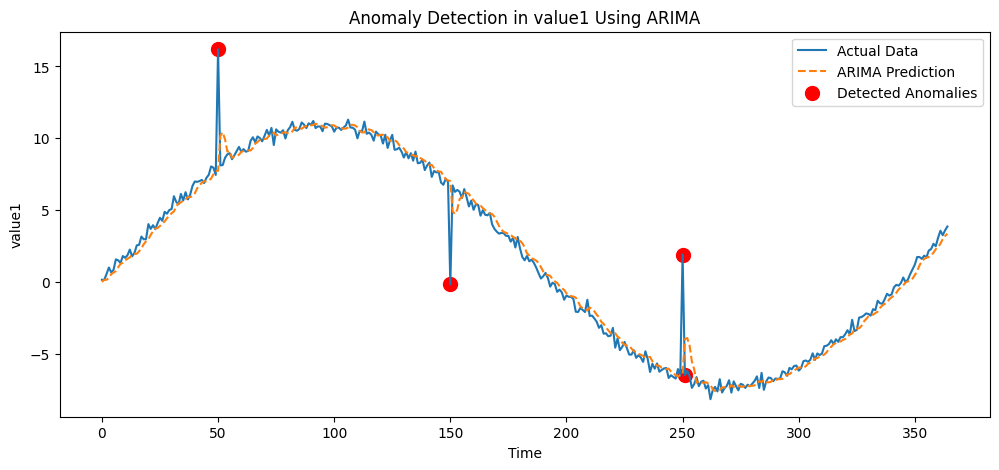


Processing column: value2


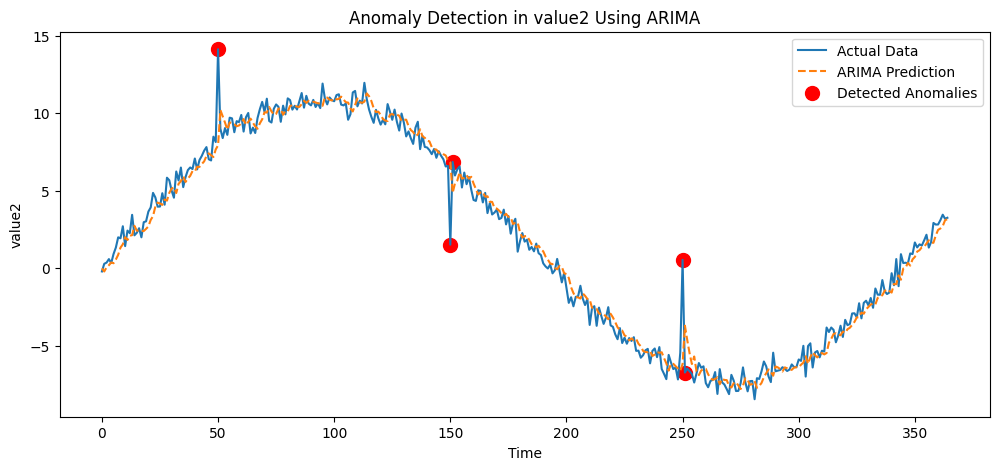


Anomalies in value1:
        value1  value1_predicted  value1_residual
50   16.197050          7.732745         8.464305
150  -0.173686          7.024032         7.197718
250   1.906408         -6.440778         8.347186
251  -6.495308         -3.995890         2.499418

Anomalies in value2:
        value2  value2_predicted  value2_residual
50   14.125582          7.931278         6.194304
150   1.528861          6.834966         5.306104
151   6.863933          4.860046         2.003887
250   0.549284         -6.160166         6.709450
251  -6.715969         -3.693481         3.022488


In [ ]:
# Generate synthetic time series data
np.random.seed(42)
t = np.linspace(0, 365, 365)
seasonal_pattern = 10 * np.sin(2 * np.pi * t / 365)
trend = 0.01 * t
noise = np.random.normal(0, 0.3, 365)
data1 = seasonal_pattern + trend + noise
data2 = seasonal_pattern + trend + np.random.normal(0, 0.5, 365)  # Another time series

# Inject anomalies
anomaly_indices = [50, 150, 250]
anomaly_values = [8, -7, 9]
for idx, val in zip(anomaly_indices, anomaly_values):
    data1[idx] += val
    data2[idx] += val * 0.8  # Slightly different anomaly

# Create DataFrame
df = pd.DataFrame({'value1': data1, 'value2': data2})

# Run anomaly detection for all columns
all_anomalies, df_with_anomalies = detect_anomalies_arima_all(df, order=(5,1,0), threshold_factor=3)

# Print detected anomalies for each feature
for col, anomalies in all_anomalies.items():
    print(f"\nAnomalies in {col}:")
    print(anomalies[[col, f'{col}_predicted', f'{col}_residual']].head())


**Performing Stationary Test**

In [ ]:
analysis_df = outlier_df.copy()

In [ ]:
def stationary_test(df, feature):
    df = df.copy()
    result = adfuller(feature.dropna())
    adf_results = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }
    return adf_results


In [ ]:
from statsmodels.tsa.stattools import adfuller

def stationary_test(df, feature):
    df = df.copy()
    result = adfuller(feature.dropna())  # ADF test result
    adf_results = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

    # Determine if series is stationary based on the ADF test
    if result[1] < 0.05:  # If p-value < 0.05, we reject the null hypothesis (non-stationary)
        is_stationary = True
    else:
        is_stationary = False

    # Checking if ADF statistic is less than critical values at 5% level
    if result[0] < adf_results['Critical Values']['5%']:
        stationary_check = True  # Rejects the null hypothesis
    else:
        stationary_check = False  # Fails to reject the null hypothesis

    # Output results with the determination of stationarity
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    print(f"Is Stationary Based on p-value: {is_stationary}")
    print(f"Is Stationary Based on ADF Statistic vs Critical Value: {stationary_check}")
    print()

    return adf_results, is_stationary, stationary_check




In [ ]:
for feature in analysis_df:
  print(f"Performing stationary test for {feature}")
  adf_results = stationary_test(analysis_df,analysis_df[feature])
  print(adf_results)
  print()

Performing stationary test for date
ADF Statistic: -8.667053721733929
p-value: 4.6538011304848703e-14
Critical Values: {'1%': -3.4339481027788024, '5%': -2.8631293617920544, '10%': -2.5676161227508754}
Is Stationary Based on p-value: True
Is Stationary Based on ADF Statistic vs Critical Value: True

({'ADF Statistic': -8.667053721733929, 'p-value': 4.6538011304848703e-14, 'Critical Values': {'1%': -3.4339481027788024, '5%': -2.8631293617920544, '10%': -2.5676161227508754}}, True, True)

Performing stationary test for fuel_consumption
ADF Statistic: -2.1697650641510102
p-value: 0.21740138435191125
Critical Values: {'1%': -3.4339323339630248, '5%': -2.863122400533316, '10%': -2.5676124161116403}
Is Stationary Based on p-value: False
Is Stationary Based on ADF Statistic vs Critical Value: False

({'ADF Statistic': -2.1697650641510102, 'p-value': 0.21740138435191125, 'Critical Values': {'1%': -3.4339323339630248, '5%': -2.863122400533316, '10%': -2.5676124161116403}}, False, False)

Perfor

The Dataset should perform, Differences to make it for better forecasting

**Performing Rolling Statistics**

In [ ]:
import matplotlib.pyplot as plt

def rolling_stats(df, feature, window=4):
    df = df.copy()  # Ensure df is properly copied
    if df[feature].dtype not in ['int64', 'float64']:  # Skip non-numeric columns
        print(f"Skipping {feature}: Not a numeric column")
        return

    df[feature + "_rmean"] = df[feature].rolling(window=window).mean()

    # Plot original feature and rolling mean
    df[[feature, feature + "_rmean"]].plot(figsize=(12, 6), title="Rolling Mean of " + feature)
    plt.show()



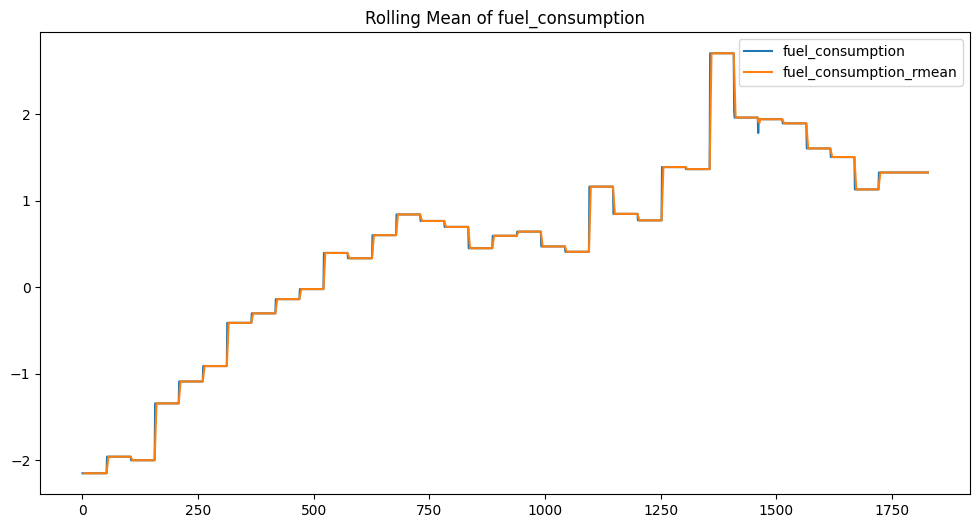

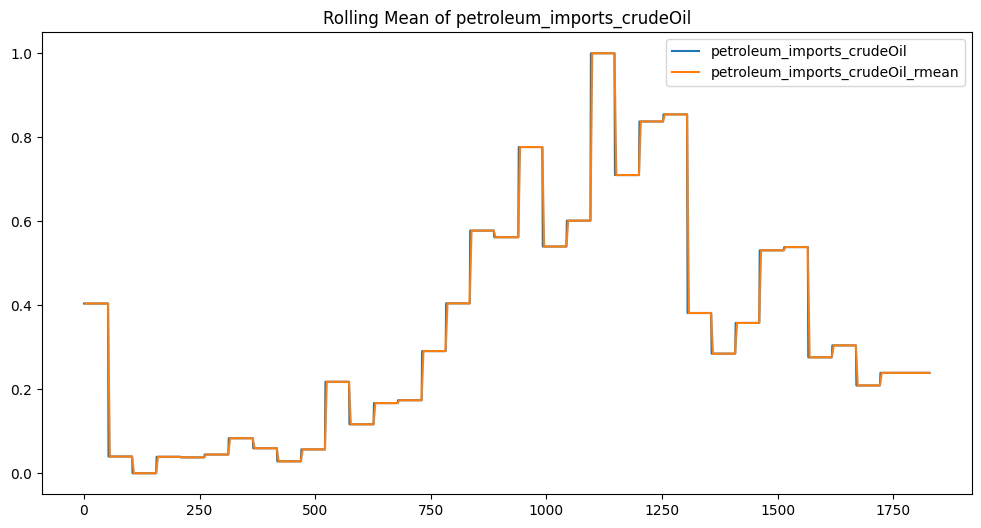

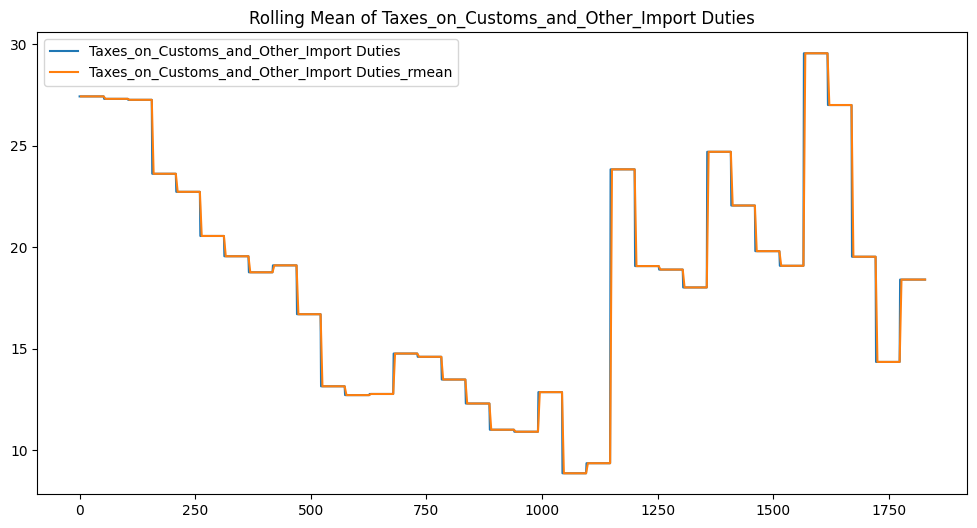

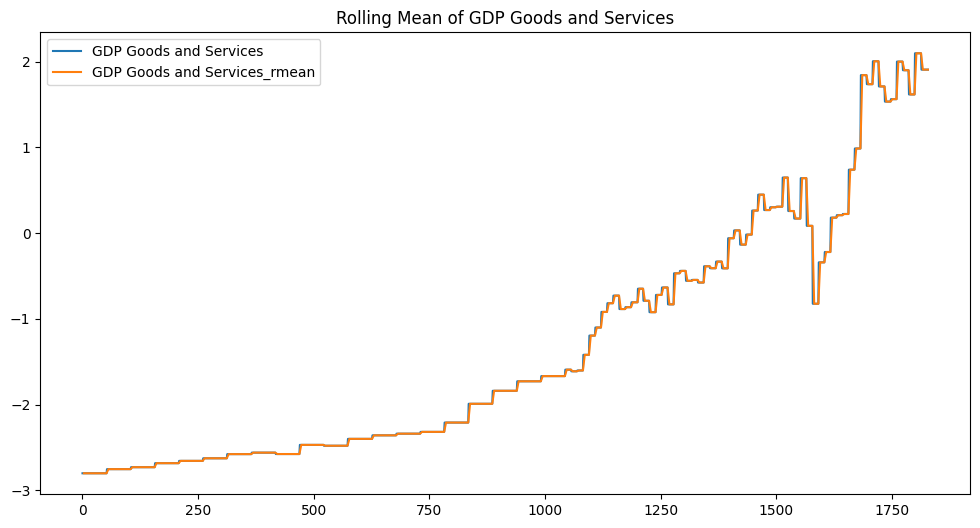

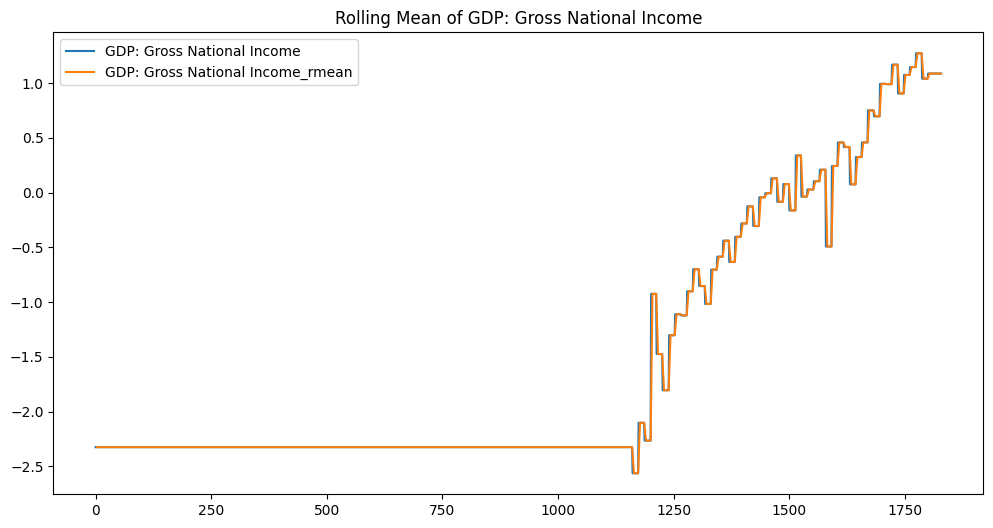

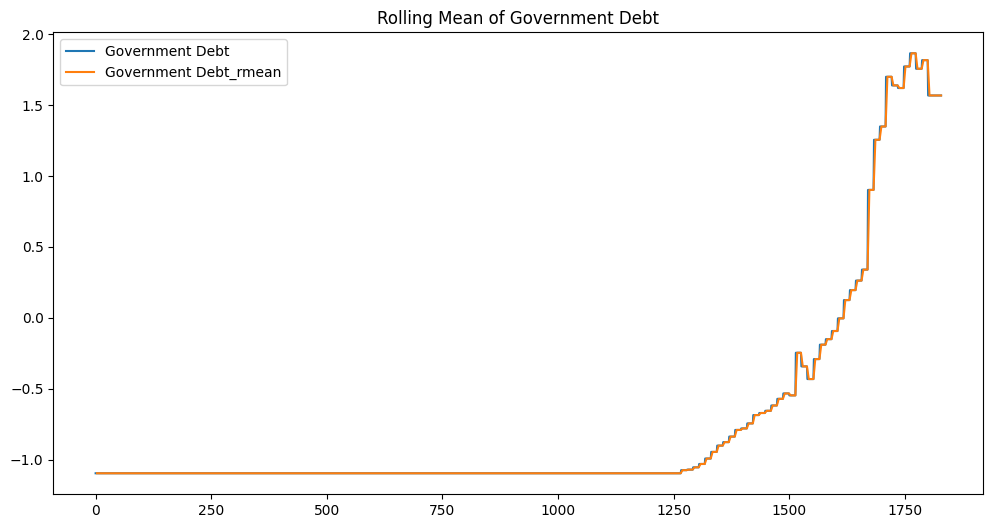

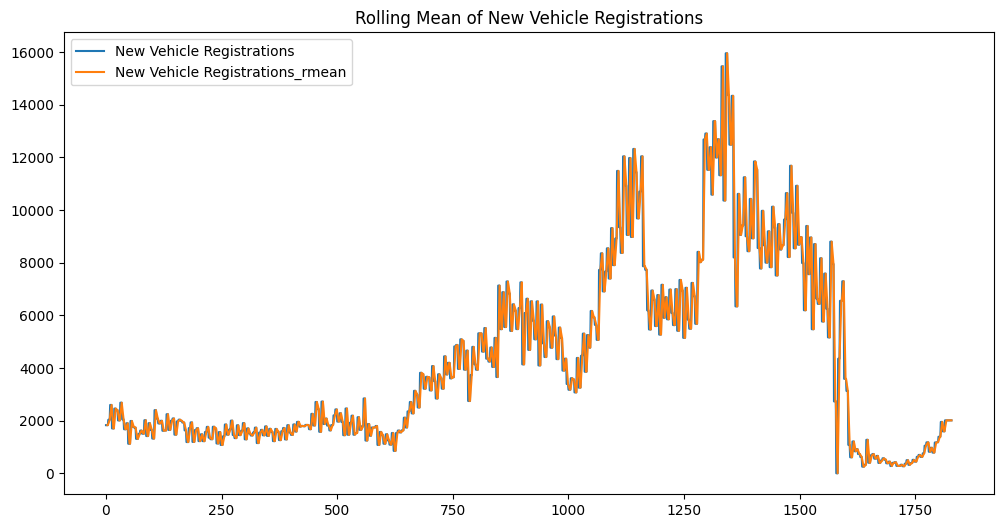

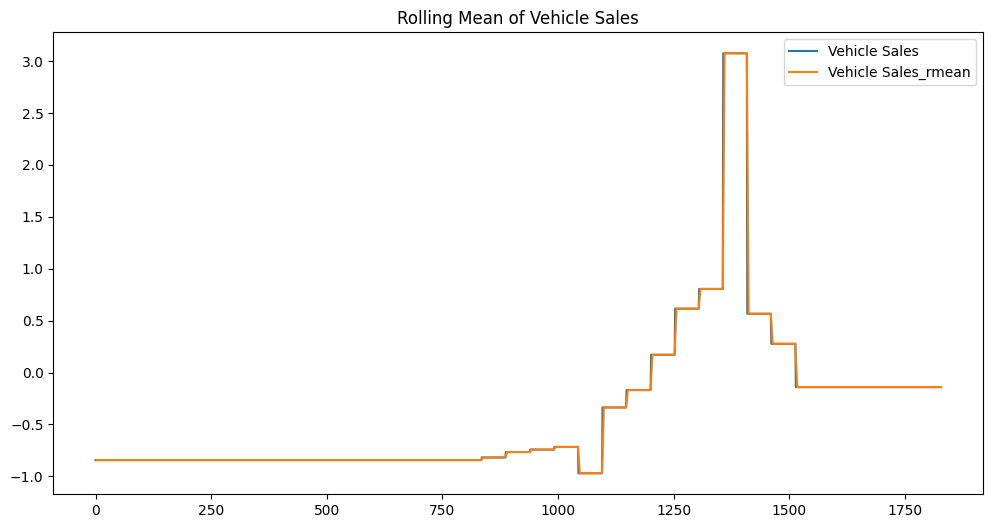

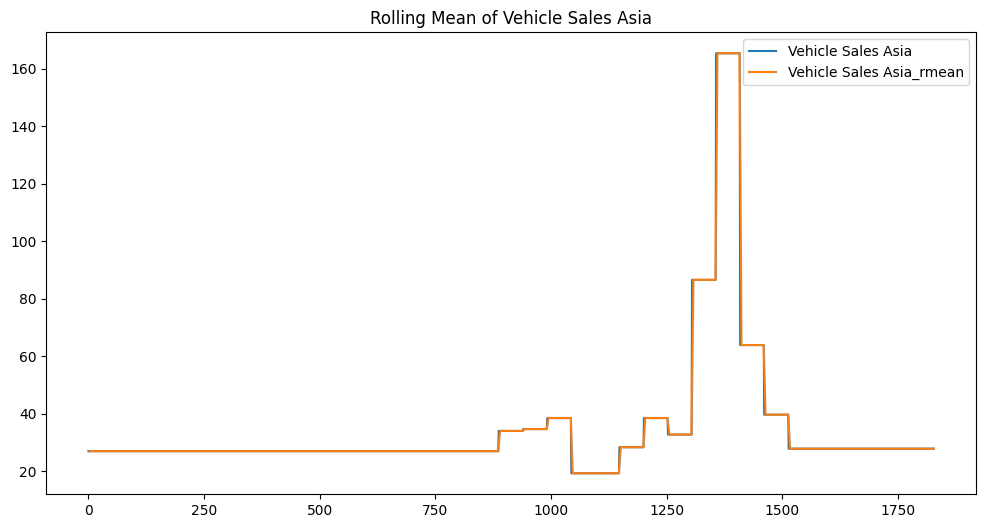

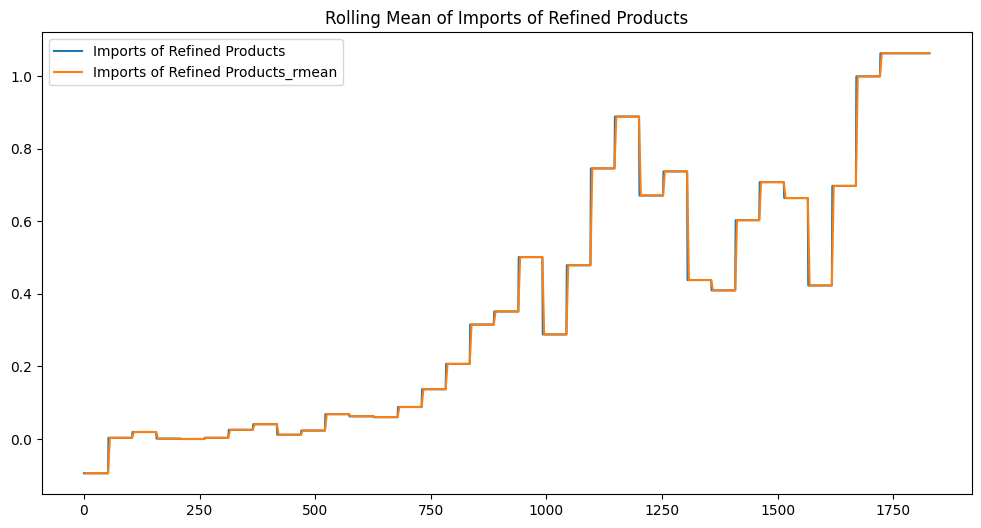

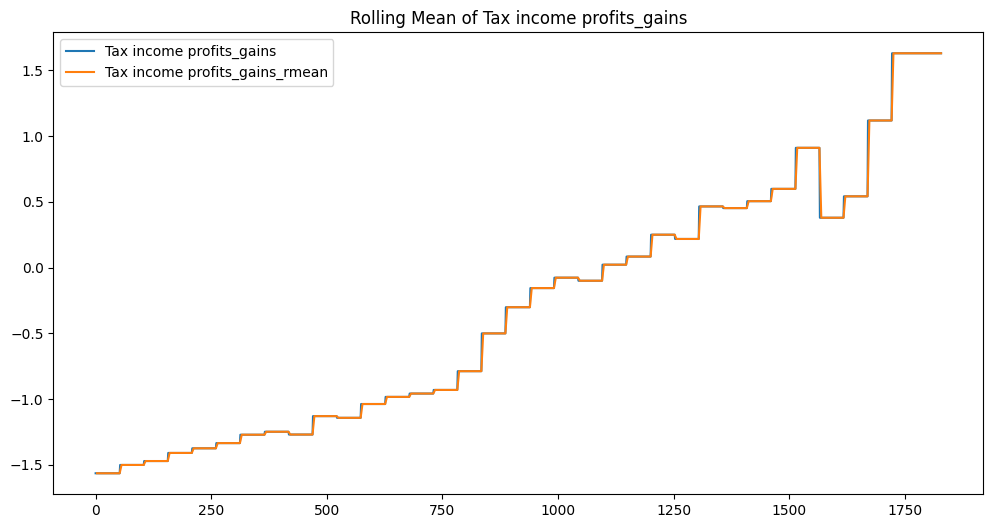

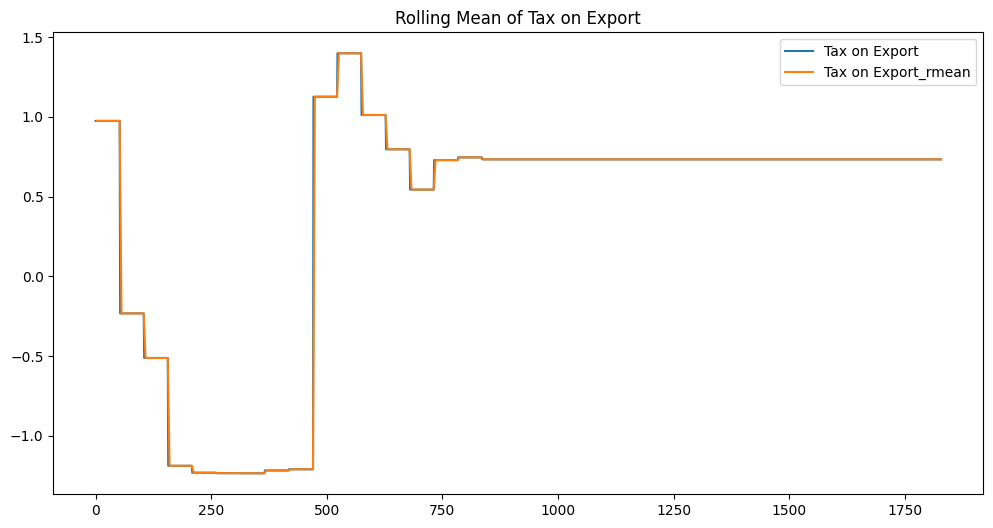

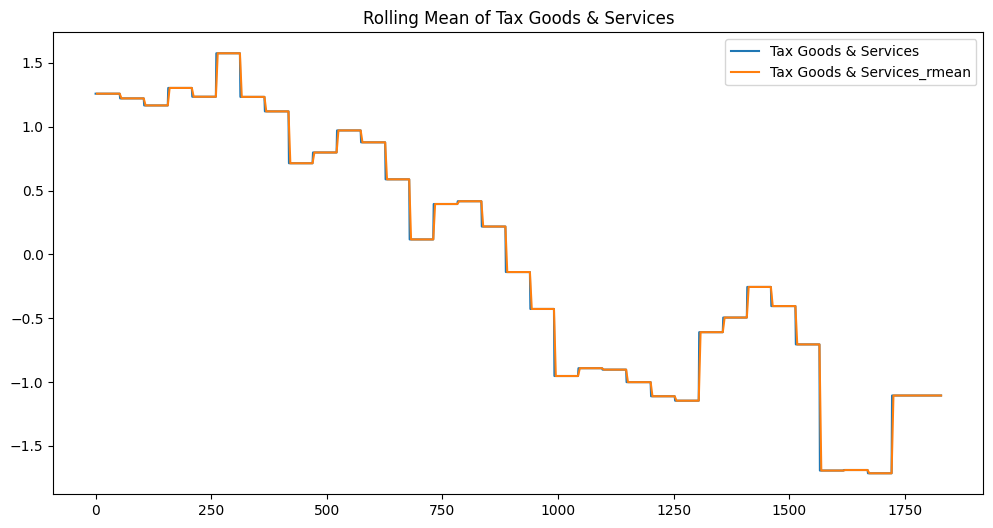

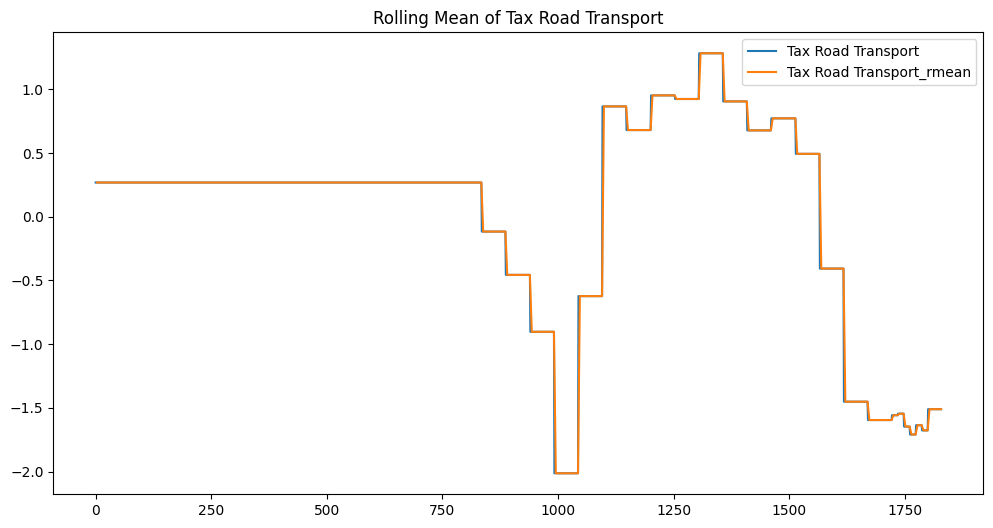

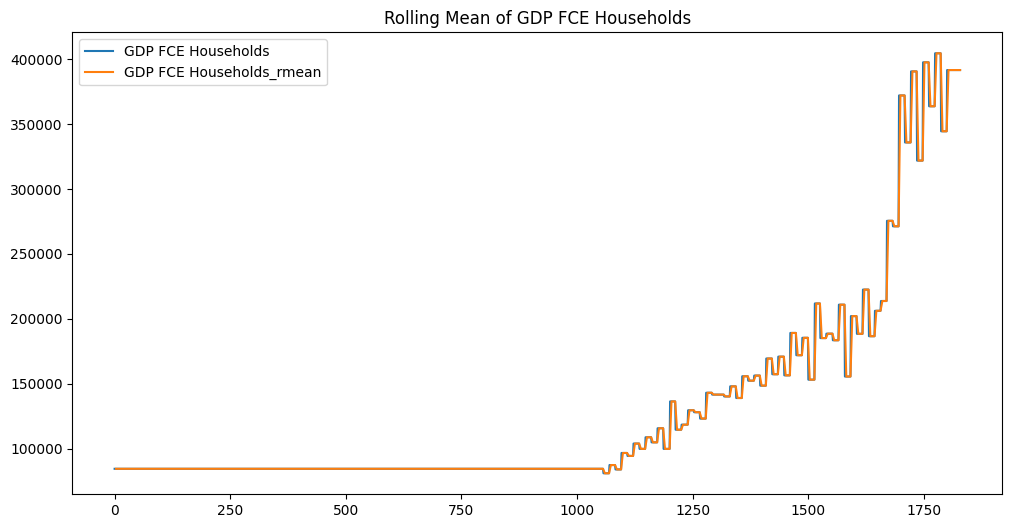

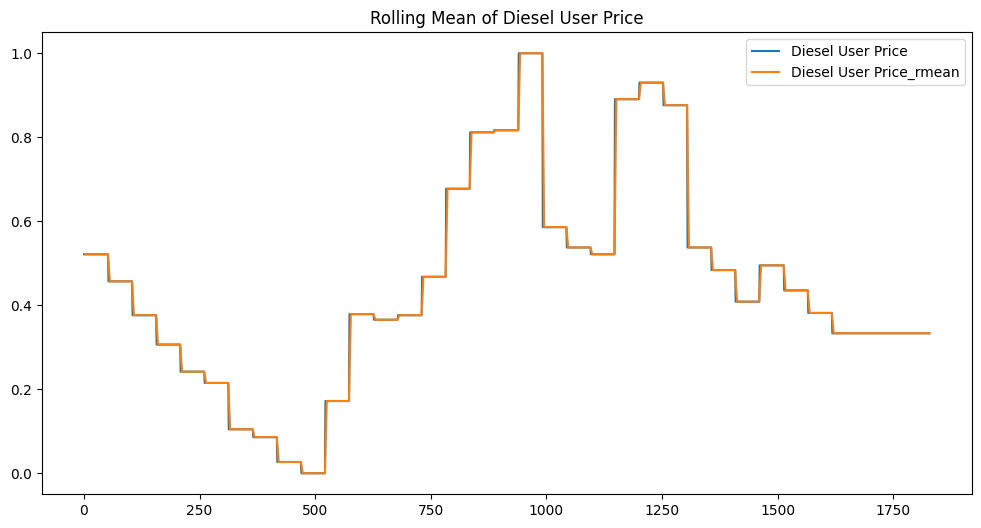

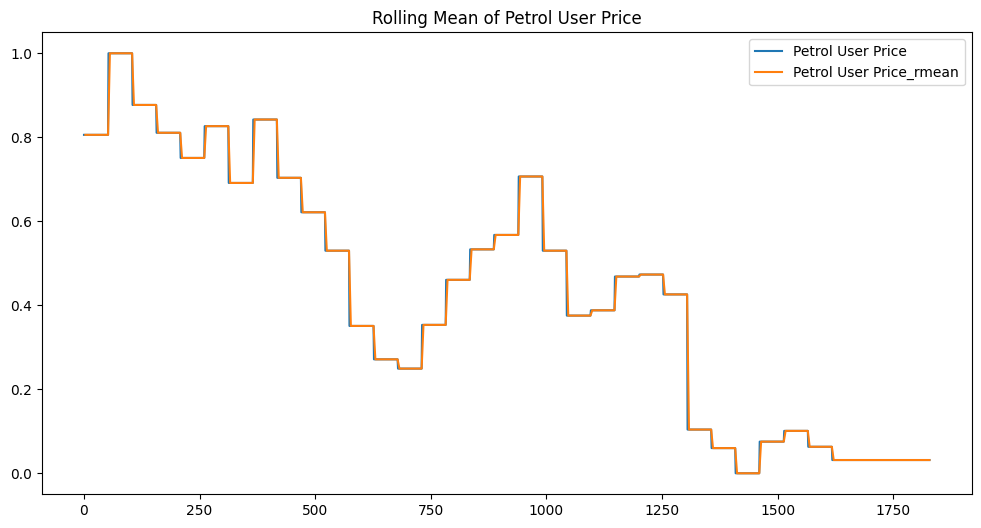

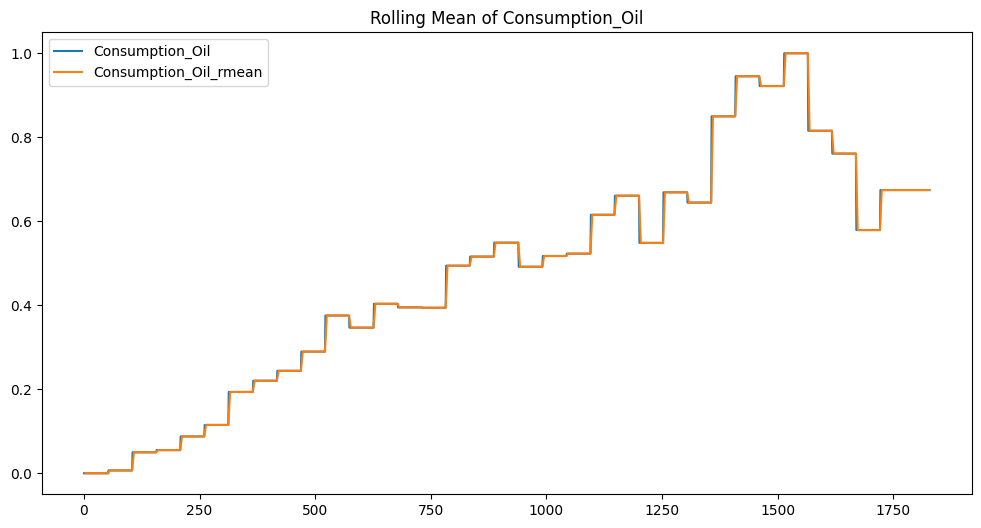

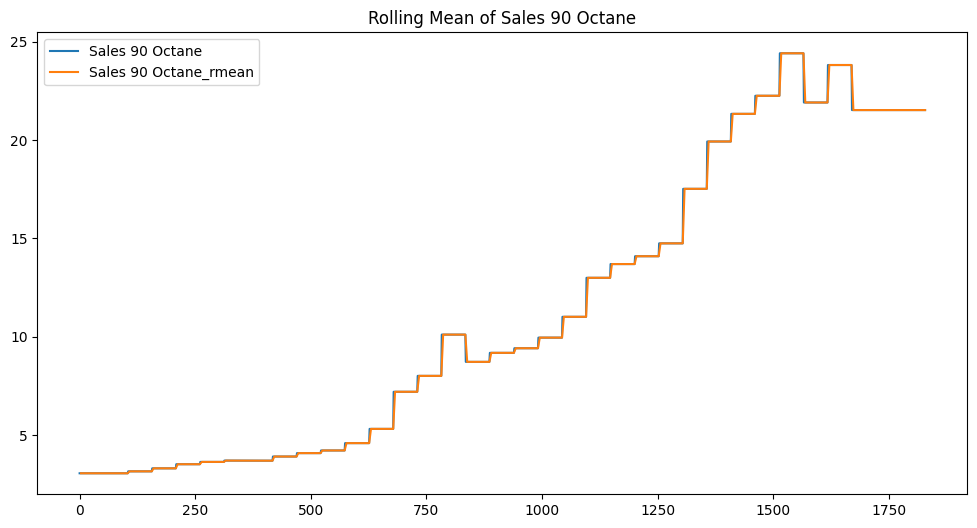

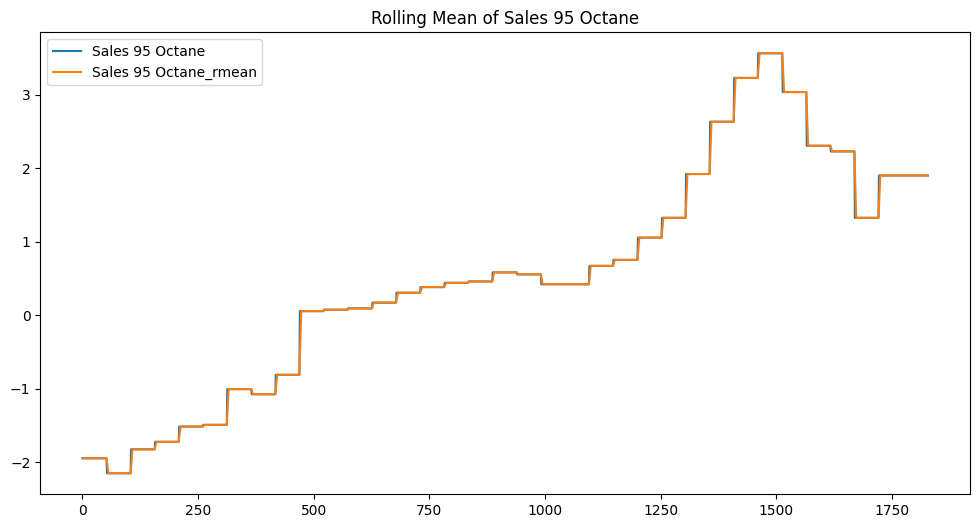

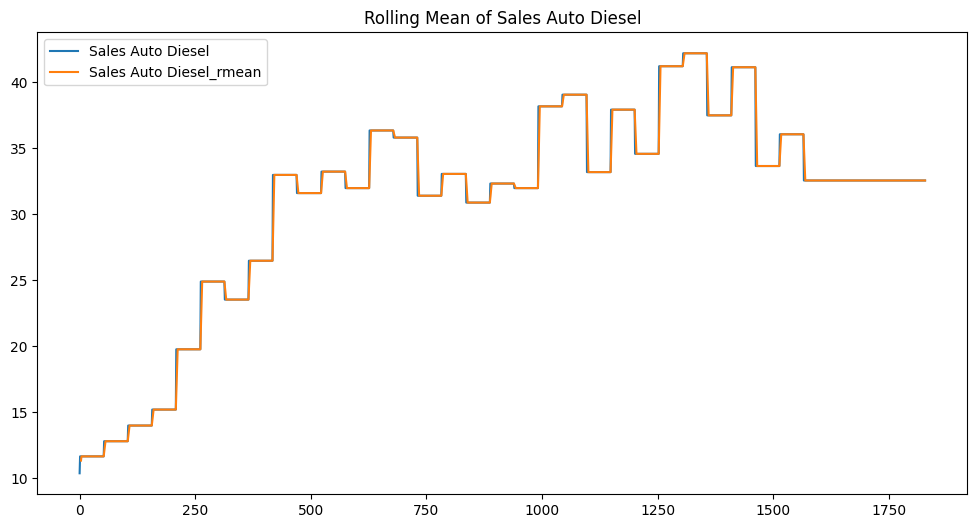

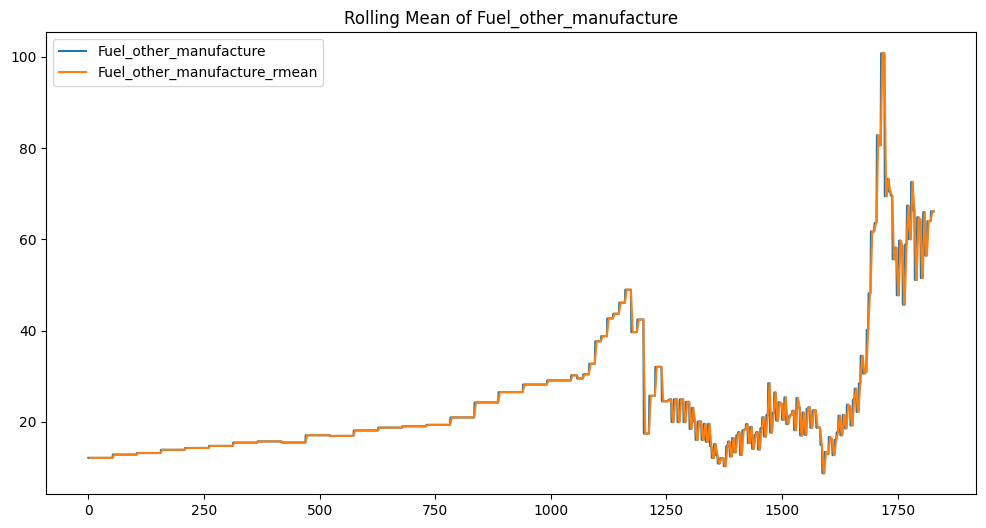

In [ ]:
# Iterate only over numeric columns
for feature in analysis_df.select_dtypes(include=['number']).columns:
    rolling_stats(analysis_df, feature)


**Seasonal Decomposition**

In [ ]:
def seasonal_decomp(df,feature):
  df = df.copy()
  result = seasonal_decompose(df[feature], model='additive', period=30)

  seasonal_df = pd.DataFrame({
      'Trend':result.trend,
      'Seasonal':result.seasonal,
      'Residual':result.resid
  })
  print("Seasonal decompose for "+feature)
  print(result)
  result.plot()
  print()

Seasonal decompose for date

Seasonal decompose for fuel_consumption

Seasonal decompose for petroleum_imports_crudeOil

Seasonal decompose for Taxes_on_Customs_and_Other_Import Duties

Seasonal decompose for GDP Goods and Services

Seasonal decompose for GDP: Gross National Income

Seasonal decompose for Government Debt

Seasonal decompose for New Vehicle Registrations

Seasonal decompose for Vehicle Sales

Seasonal decompose for Vehicle Sales Asia

Seasonal decompose for Imports of Refined Products

Seasonal decompose for Tax income profits_gains

Seasonal decompose for Tax on Export

Seasonal decompose for Tax Goods & Services

Seasonal decompose for Tax Road Transport

Seasonal decompose for GDP FCE Households

Seasonal decompose for Diesel User Price

Seasonal decompose for Petrol User Price

Seasonal decompose for Consumption_Oil

Seasonal decompose for Sales 90 Octane

Seasonal decompose for Sales 95 Octane



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/seasonal.py:346: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(len(series), 1, sharex=True)


Seasonal decompose for Sales Auto Diesel

Seasonal decompose for Fuel_other_manufacture



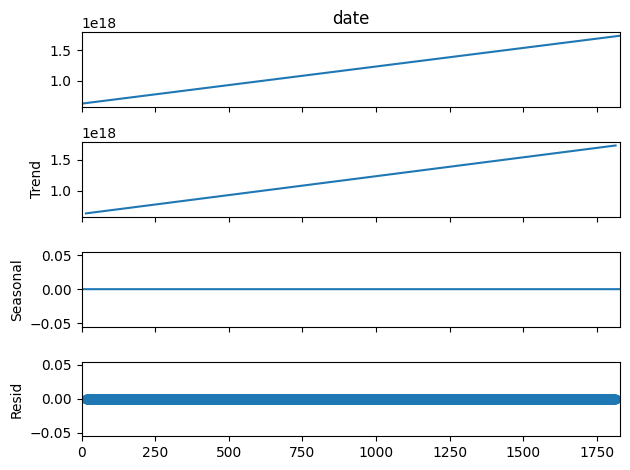

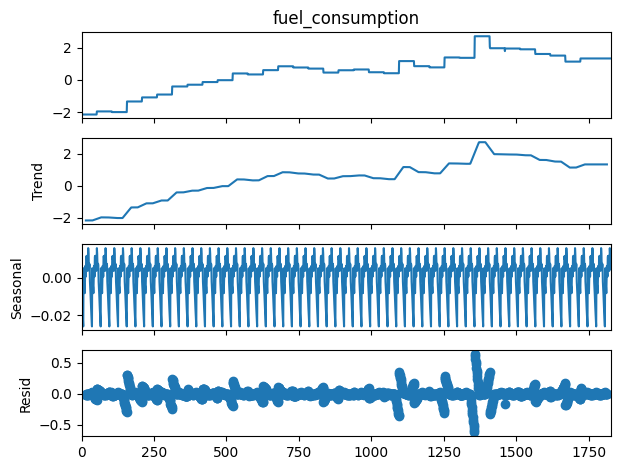

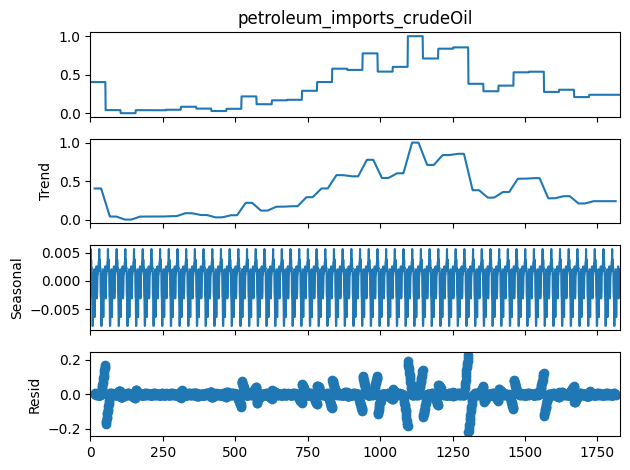

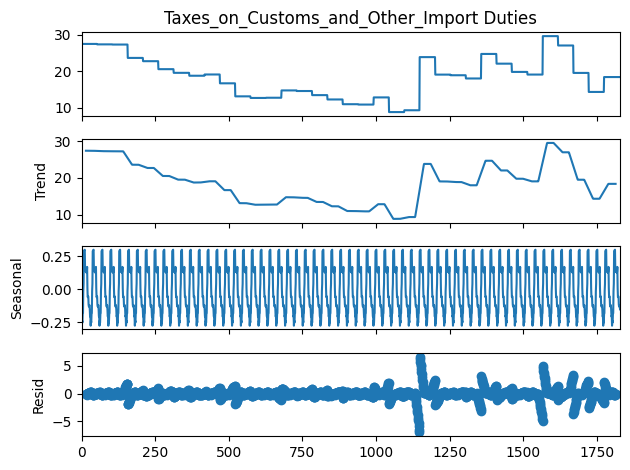

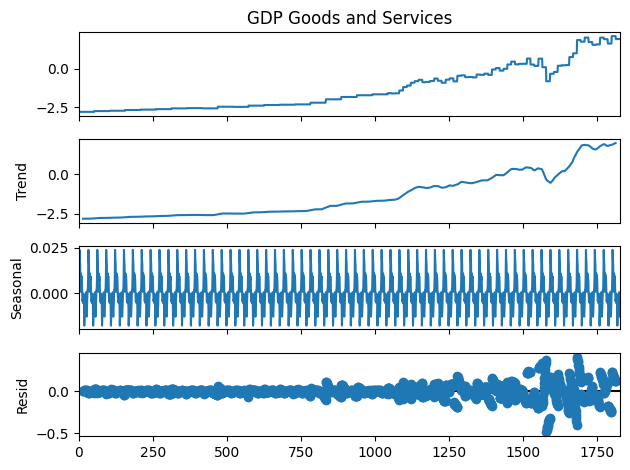

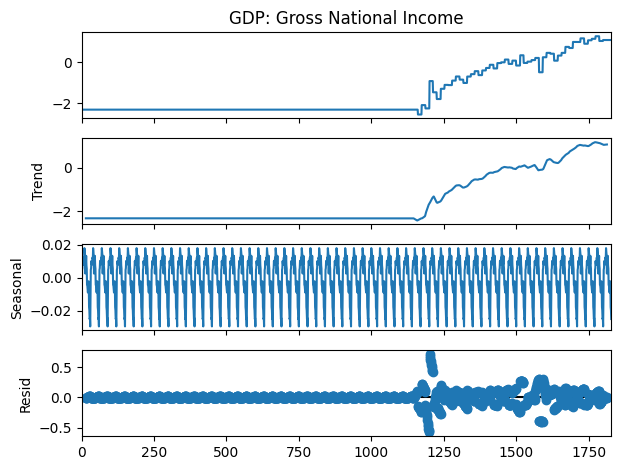

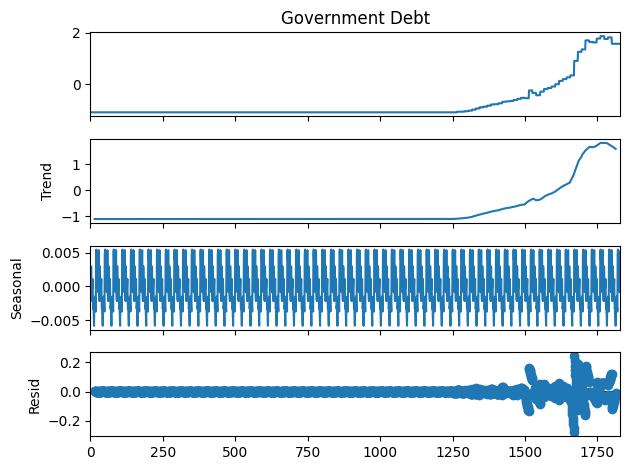

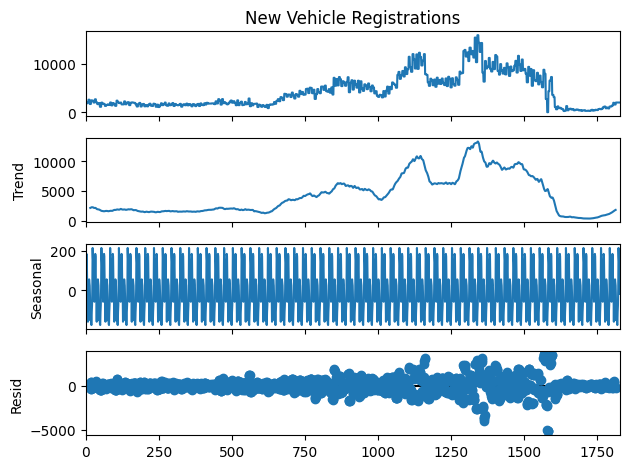

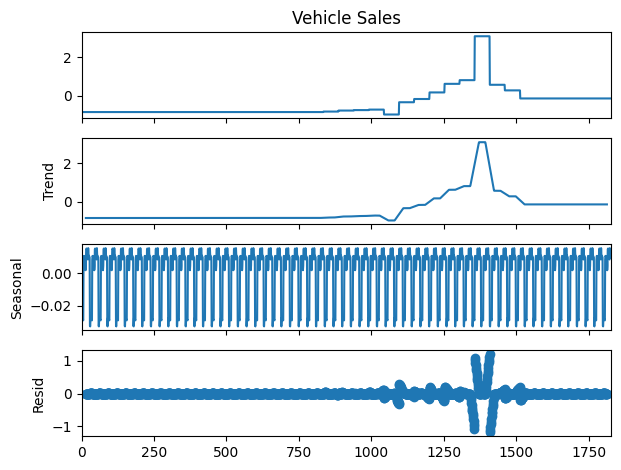

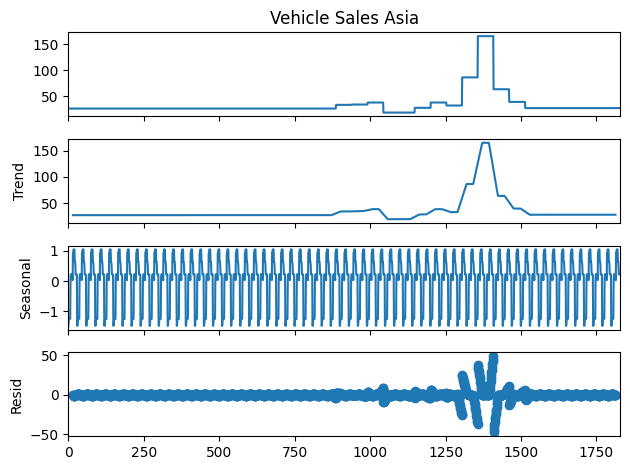

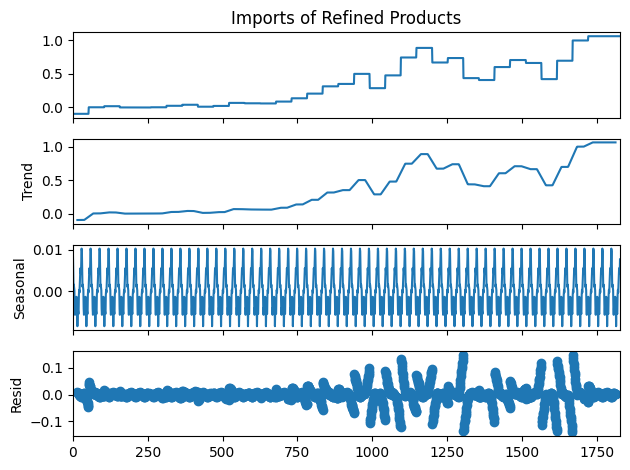

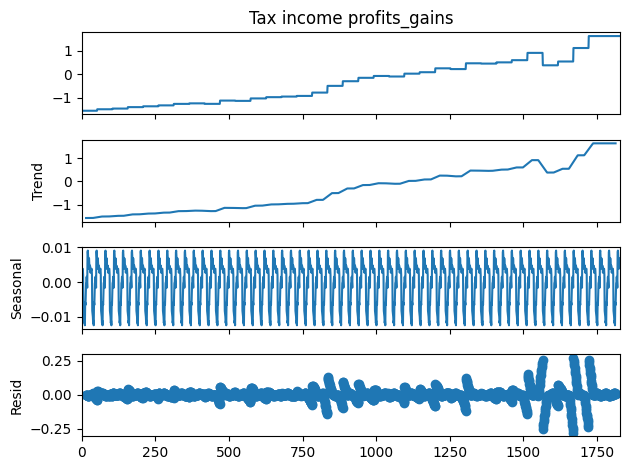

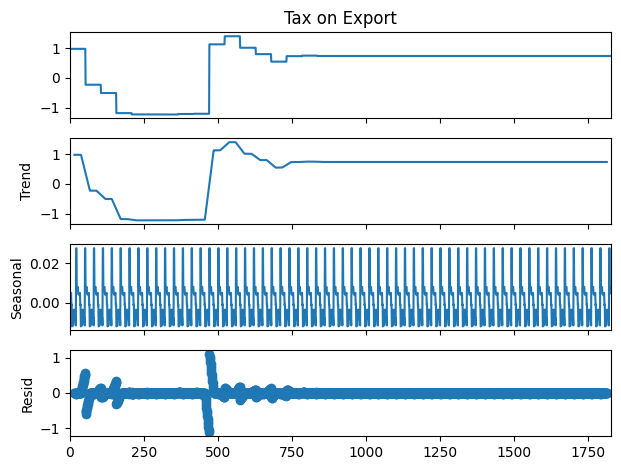

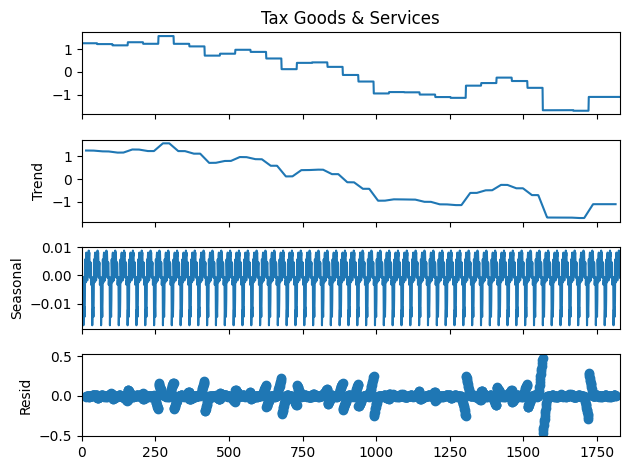

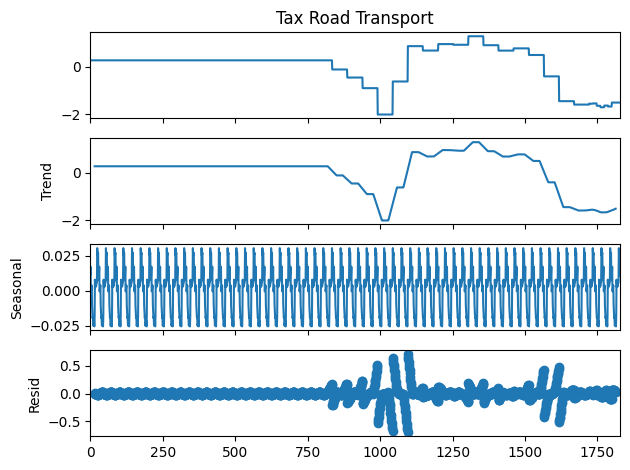

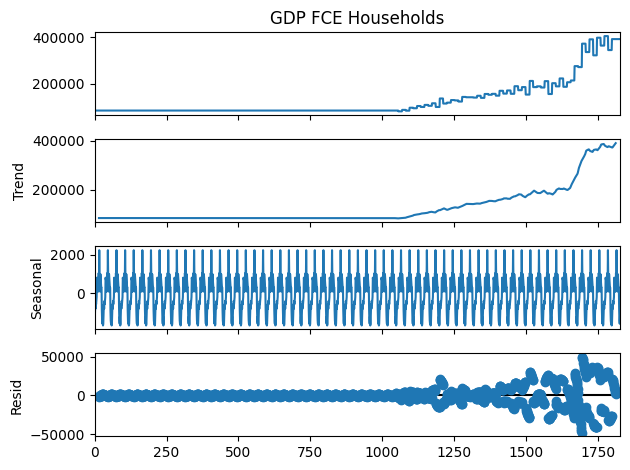

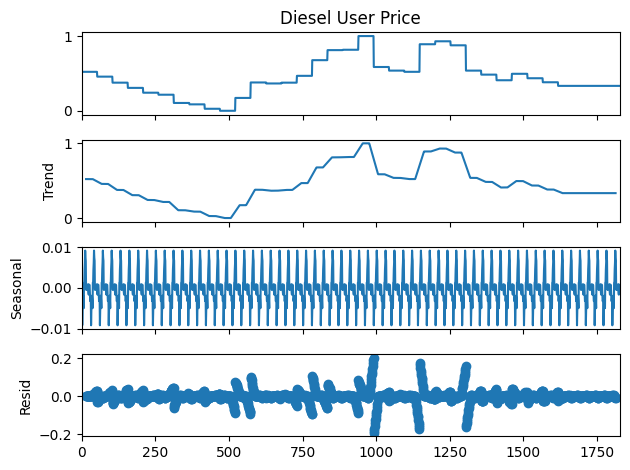

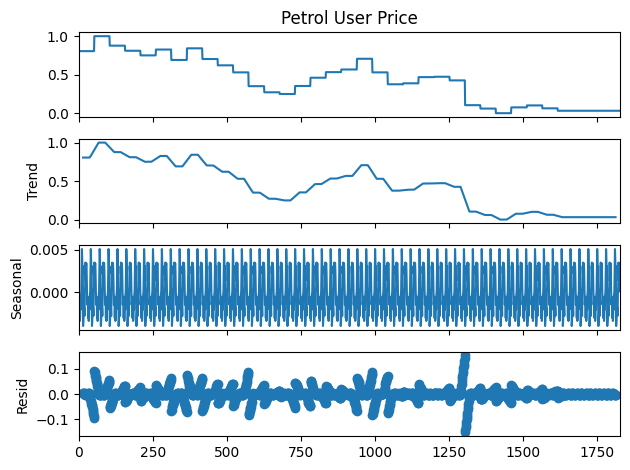

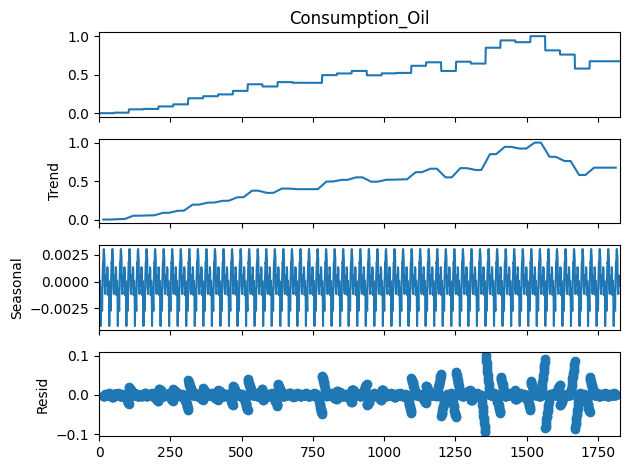

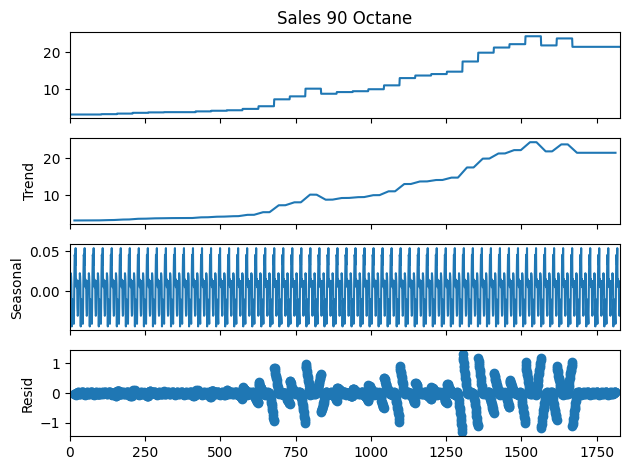

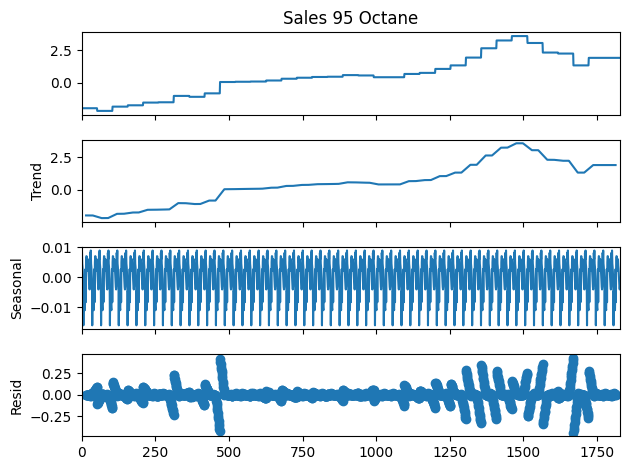

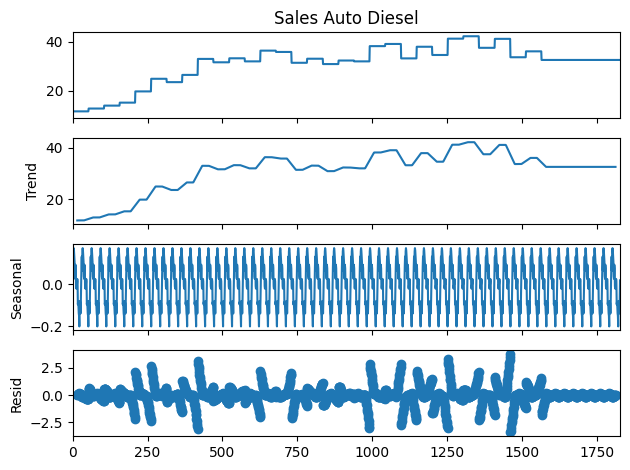

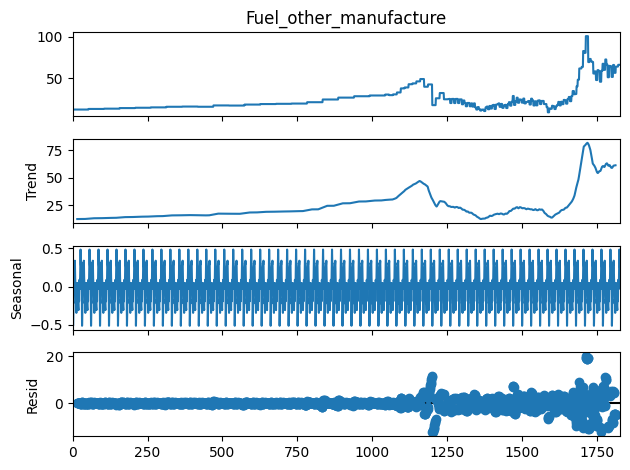

In [ ]:
for feature in analysis_df.columns:
  seasonal_decomp(analysis_df,feature)

**Seasonal Strength**

In [224]:
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_strength(df, feature, period=30):
    result = seasonal_decompose(df[feature], model='additive', period=period, extrapolate_trend='freq')

    # Extract seasonal and residual components
    seasonal_component = result.seasonal
    residual_component = result.resid

    # Handle NaNs
    if seasonal_component.isna().all() or residual_component.isna().all():
        print(f"Skipping {feature}: Decomposition returned NaN values")
        return None

    # Variance calculations
    var_seasonal = np.nanvar(seasonal_component)  # Ignore NaNs in variance
    var_residual = np.nanvar(residual_component)

    # Avoid division by zero
    denominator = var_seasonal + var_residual
    if denominator == 0:
        print(f"Skipping {feature}: Zero variance in seasonal and residual components")
        return None

    # Compute seasonal strength
    strength = var_seasonal / denominator
    print(f"Seasonal Strength for {feature}: {strength:.4f}")
    return strength



In [226]:
for feature in analysis_df.columns:
    seasonal_strength(analysis_df, feature)


Seasonal Strength for date: 0.0161
Seasonal Strength for fuel_consumption: 0.0160
Seasonal Strength for petroleum_imports_crudeOil: 0.0083
Seasonal Strength for Taxes_on_Customs_and_Other_Import Duties: 0.0393
Seasonal Strength for GDP Goods and Services: 0.0148
Seasonal Strength for GDP: Gross National Income: 0.0164
Seasonal Strength for Government Debt: 0.0115
Seasonal Strength for New Vehicle Registrations: 0.0148
Seasonal Strength for Vehicle Sales: 0.0182
Seasonal Strength for Vehicle Sales Asia: 0.0245
Seasonal Strength for Imports of Refined Products: 0.0239
Seasonal Strength for Tax income profits_gains: 0.0212
Seasonal Strength for Tax on Export: 0.0099
Seasonal Strength for Tax Goods & Services: 0.0117
Seasonal Strength for Tax Road Transport: 0.0218
Seasonal Strength for GDP FCE Households: 0.0084
Seasonal Strength for Diesel User Price: 0.0155
Seasonal Strength for Petrol User Price: 0.0108
Seasonal Strength for Consumption_Oil: 0.0087
Seasonal Strength for Sales 90 Octane

The dataset has very weak seasonality, so the reason for the non-stationary is not the seasonality of the dataset

**Autocorrelation & Partial Autocorrelation (ACF/PACF)**

In [229]:
def acf_pacf(df,feature):
  acf_values = acf(df[feature].dropna(), nlags=10)
  pacf_values = pacf(df[feature].dropna(), nlags=10)

  acf_df = pd.DataFrame({'Lag':range(11), 'ACF':acf_values})
  pacf_df = pd.DataFrame({'Lag':range(11), 'PACF':pacf_values})
  print("ACF and PACF for ",feature)
  print("Autocorrelation Values:")
  print(acf_df)
  print("\nPartial Autocorrelation Values:")
  print(pacf_df)

In [230]:
for feature in analysis_df.columns:
  acf_pacf(analysis_df,feature)

ACF and PACF for  date
Autocorrelation Values:
    Lag       ACF
0     0  1.000000
1     1  0.998360
2     2  0.996720
3     3  0.995079
4     4  0.993439
5     5  0.991799
6     6  0.990159
7     7  0.988518
8     8  0.986878
9     9  0.985238
10   10  0.983598

Partial Autocorrelation Values:
    Lag      PACF
0     0  1.000000
1     1  0.998906
2     2 -0.001094
3     3 -0.001095
4     4 -0.001095
5     5 -0.001096
6     6 -0.001097
7     7 -0.001097
8     8 -0.001098
9     9 -0.001098
10   10 -0.001099
ACF and PACF for  fuel_consumption
Autocorrelation Values:
    Lag       ACF
0     0  1.000000
1     1  0.997435
2     2  0.994860
3     3  0.992285
4     4  0.989710
5     5  0.987135
6     6  0.984560
7     7  0.981985
8     8  0.979410
9     9  0.976835
10   10  0.974260

Partial Autocorrelation Values:
    Lag      PACF
0     0  1.000000
1     1  0.997980
2     2 -0.003912
3     3 -0.001561
4     4 -0.001569
5     5 -0.001572
6     6 -0.001575
7     7 -0.001577
8     8 -0.001580


In [231]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

def acf_pacf_strength(df, feature, nlags=10):
    acf_values = acf(df[feature].dropna(), nlags=nlags)
    pacf_values = pacf(df[feature].dropna(), nlags=nlags)

    # Compute how quickly ACF declines (higher means strong trend)
    acf_strength = np.sum(np.abs(acf_values[1:])) / nlags  # Ignore lag 0 (always 1)

    # Check if PACF drops off after the first lag (higher means trend)
    pacf_strength = abs(pacf_values[1])  # PACF at lag 1 shows direct correlation

    print(f"{feature}: ACF Strength = {acf_strength:.4f}, PACF Strength = {pacf_strength:.4f}")

    return acf_strength, pacf_strength

# Run for all columns
for feature in analysis_df.columns:
    acf_pacf_strength(analysis_df, feature)


date: ACF Strength = 0.9910, PACF Strength = 0.9989
fuel_consumption: ACF Strength = 0.9858, PACF Strength = 0.9980
petroleum_imports_crudeOil: ACF Strength = 0.9800, PACF Strength = 0.9969
Taxes_on_Customs_and_Other_Import Duties: ACF Strength = 0.9684, PACF Strength = 0.9948
GDP Goods and Services: ACF Strength = 0.9865, PACF Strength = 0.9981
GDP: Gross National Income: ACF Strength = 0.9863, PACF Strength = 0.9981
Government Debt: ACF Strength = 0.9843, PACF Strength = 0.9977
New Vehicle Registrations: ACF Strength = 0.9327, PACF Strength = 0.9829
Vehicle Sales: ACF Strength = 0.9673, PACF Strength = 0.9946
Vehicle Sales Asia: ACF Strength = 0.9508, PACF Strength = 0.9916
Imports of Refined Products: ACF Strength = 0.9832, PACF Strength = 0.9975
Tax income profits_gains: ACF Strength = 0.9882, PACF Strength = 0.9984
Tax on Export: ACF Strength = 0.9799, PACF Strength = 0.9969
Tax Goods & Services: ACF Strength = 0.9909, PACF Strength = 0.9989
Tax Road Transport: ACF Strength = 0.97

Since the data is heavily dependent on the past values and not seasonality, focusing on the "Trends" is the main priority.

**Lag Analysis**

In [232]:
def lag_analysis(df,feature):
  df[feature+'lag1'] = df[feature].shift(1)

  # Show numerical correlation
  lag_corr = df[[feature,feature+'lag1']].corr().iloc[0,1]
  print("Correlation between",feature,"and its 1-day lag:",lag_corr)

In [233]:
for feature in analysis_df.columns:
  lag_analysis(analysis_df,feature)

Correlation between date and its 1-day lag: 0.8191130117890565
Correlation between fuel_consumption and its 1-day lag: 0.9989945142357228
Correlation between petroleum_imports_crudeOil and its 1-day lag: 0.9964219525498085
Correlation between Taxes_on_Customs_and_Other_Import Duties and its 1-day lag: 0.994967027509982
Correlation between GDP Goods and Services and its 1-day lag: 0.9993263774098607
Correlation between GDP: Gross National Income and its 1-day lag: 0.9989401287854892
Correlation between Government Debt and its 1-day lag: 0.9996012426210554
Correlation between New Vehicle Registrations and its 1-day lag: 0.9825976334032895
Correlation between Vehicle Sales and its 1-day lag: 0.9941831172832308
Correlation between Vehicle Sales Asia and its 1-day lag: 0.9911125320569797
Correlation between Imports of Refined Products and its 1-day lag: 0.9985219056125834
Correlation between Tax income profits_gains and its 1-day lag: 0.99957170342346
Correlation between Tax on Export and i

**Correlation Matrix**

          value1    value2
value1  1.000000  0.995208
value2  0.995208  1.000000


<Axes: >

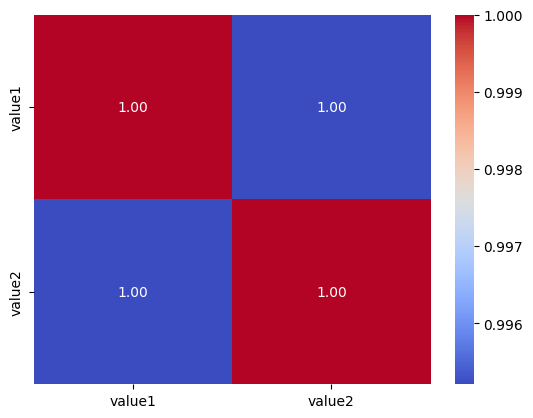

In [234]:
corr_matrix = df.corr()
print(corr_matrix)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

## **Augmenting the Data and Transforming columns**

**Making the dataset Stationary**